In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from src import setup
# setup.use_gpu()

from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo

In [2]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/greedy")

In [3]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/mimic")

In [4]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/landscape_maximizes")

In [5]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/random")

In [3]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM

In [4]:
newdata1 = dict(h5py.File("../data/random/random.hdf5"))
newdata2 = dict(h5py.File("../data/greedy/greedy.hdf5"))
newdata3 = dict(h5py.File("../data/mimic/mimic.hdf5"))
newdata4 = dict(h5py.File("../data/landscape_maximizes/landscape_maximizes.hdf5"))

In [5]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [6]:
#MI of every pair
def mutual_info_dicts(twoQdms, trial_index):
    mutual_info_list = []
    for time_step in twoQdms[trial_index]:
        mutual_info_dict = {}
        mutual_info = measure.mutual_information_of_every_pair_dict(time_step)
        # Filter out values below the precision threshold
        filtered_mutual_info = {k: v if v >= 1e-6 else 0 for k, v in mutual_info.items()}
        # Update the mutual_info_dict with the filtered mutual info for the current time step
        mutual_info_dict.update(filtered_mutual_info)
        # Append the mutual_info_dict to the list
        mutual_info_list.append(mutual_info_dict)
    return mutual_info_list

In [7]:
# Call the two_point_dict function for each trial index
# Get the list of dictionaries containing two point values for each time step
def create_adjacency_matrix_two_dim(two_point_dict, num_nodes):
    adjacency_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    for (node1, node2), two_point_value in two_point_dict.items():
        adjacency_matrix[node1][node2] = two_point_value
        adjacency_matrix[node2][node1] = two_point_value  # Assuming undirected graph
    return adjacency_matrix
    
def adjacency_matrices_list_two_dim(twoQdms, trial_index, num_nodes, two_point_dicts):
    # Get the list of dictionaries containing mutual information values for each time step
    two_point_dicts_list = two_point_dicts(twoQdms, trial_index)
    # Create adjacency matrices for each time step
    adjacency_matrices = []
    for two_point_dict in two_point_dicts_list:
        adj_matrix = create_adjacency_matrix_two_dim(two_point_dict, num_nodes)
        adjacency_matrices.append(adj_matrix)
    return adjacency_matrices

In [8]:
def means_stds_of_pops_of_one_sim_index(pops_trial_index):
    mean_stds_list = []
    for step_index in range(steps):
        stds = np.std(pops_trial_index [step_index])
        means = np.mean(pops_trial_index[step_index])
        mean_stds_list.append([means, stds])
    return mean_stds_list

def means_stds_mode_of_pops_of_one_sim_index(pops_trial_index):
    mean_stds_mode_list = []
    for step_index in range(steps):
        total = sum(pops_trial_index[step_index])
        stds = np.std(pops_trial_index[step_index])
        means = np.mean(pops_trial_index[step_index])
        mode = max(pops_trial_index[step_index])
        mean_stds_mode_list.append([total,stds,means,mode])
    return mean_stds_mode_list

def extract_total(list_of_lists):
    return [sublist[0] for sublist in list_of_lists]
def extract_stds(list_of_lists):
    return [sublist[1] for sublist in list_of_lists]
def extract_means(list_of_lists):
    return [sublist[2] for sublist in list_of_lists]
def extract_mode(list_of_lists):
    return [sublist[3] for sublist in list_of_lists]

In [9]:
def moving_average(data, window_size=10):
    """
    Function to calculate the moving average of a given data array.
    
    Parameters:
    - data: The input data array.
    - window_size: The size of the moving average window.
    
    Returns:
    - moving_avg: The moving average array.
    """
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    return moving_avg

def plot_four_stats_as_function_of_time(list1, list2, list3,list4, filename='plot.png',title='plotname'):
    # Assuming both lists have the same length (representing time steps)
    time_steps = range(1, len(list1) + 1)
    
    # Calculate moving averages for both lists
    moving_avg_list1 = moving_average(list1)
    moving_avg_list2 = moving_average(list2)
    moving_avg_list3 = moving_average(list3)
    moving_avg_list4 = moving_average(list4)
    
    # Set the figure size (adjust as needed)
    plt.figure(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches
    
    # Plotting the lists and their moving averages
    plt.plot(time_steps, list1, color='blue', label='Random')
    plt.plot(time_steps, list2,color='orange', label='Greedy')
    plt.plot(time_steps, list3, color='red',label='Mimic')
    plt.plot(time_steps, list4, color='green',label='Landmax')
    plt.plot(time_steps[len(list1) - len(moving_avg_list1):], moving_avg_list1, linestyle='--', color='blue', label='Moving Average (Random)')
    plt.plot(time_steps[len(list2) - len(moving_avg_list2):], moving_avg_list2, linestyle='--', color='orange', label='Moving Average (Greedy)')
    plt.plot(time_steps[len(list3) - len(moving_avg_list3):], moving_avg_list3, linestyle='--', color='red', label='Moving Average (Mimic)')
    plt.plot(time_steps[len(list4) - len(moving_avg_list4):], moving_avg_list4, linestyle='--', color='green', label='Moving Average (Landmax)')    
    
    # Adding labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    
    # Adding legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    
    # Display the plot
    plt.grid(True)
    
    # Save the plot with the desired filename
    #plt.savefig(filename)
    
    # Show the plot (optional)
    plt.show()

def plot_four_stats_as_function_of_time_avg(list1, list2, list3,list4, filename='plot.png',title='plotname'):
    # Assuming both lists have the same length (representing time steps)
    time_steps = range(1, len(list1) + 1)
    
    # Calculate moving averages for both lists
    moving_avg_list1 = moving_average(list1)
    moving_avg_list2 = moving_average(list2)
    moving_avg_list3 = moving_average(list3)
    moving_avg_list4 = moving_average(list4)
    
    # Set the figure size (adjust as needed)
    plt.figure(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches
    
    # Plotting the lists and their moving averages
    #plt.plot(time_steps, list1, color='blue', label='Random')
#    plt.plot(time_steps, list2,color='orange', label='Greedy')
    #plt.plot(time_steps, list3, color='green',label='Land_max')
    #plt.plot(time_steps, list4, color='red',label='Mimic')
    plt.plot(time_steps[len(list1) - len(moving_avg_list1):], moving_avg_list1, linestyle='--', color='blue', label='Moving Average (Random)')
    plt.plot(time_steps[len(list2) - len(moving_avg_list2):], moving_avg_list2, linestyle='--', color='orange', label='Moving Average (Greedy)')
    plt.plot(time_steps[len(list3) - len(moving_avg_list3):], moving_avg_list3, linestyle='--', color='red', label='Moving Average (Mimic)')
    plt.plot(time_steps[len(list4) - len(moving_avg_list4):], moving_avg_list4, linestyle='--', color='green', label='Moving Average (Landmax)')    
    
    # Adding labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    
    # Adding legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    
    # Display the plot
    plt.grid(True)
    
    # Save the plot with the desired filename
   # plt.savefig(filename)
    
    # Show the plot (optional)
    plt.show()

In [10]:
#Clustering Coefficient
def clustering_coeff_function_of_time(adjacency_matrix_list):
    C_list = []
    #adjacency_matrix_list=np.array(adjacency_matrix_list)
    for adj_mat in adjacency_matrix_list:
        adj_mat=np.array(adj_mat)
        M_sq = adj_mat@adj_mat
        sum_of_M_sq = np.sum(M_sq)
        M_cube = adj_mat@adj_mat@adj_mat
        M_cube_trace = np.trace(M_cube)
        C_list.append(M_cube_trace/sum_of_M_sq)
    return(C_list)

#Disparity
def disparity_function_of_time(adjacency_matrix_list, N):
    D_list = []
    for adj_mat in adjacency_matrix_list:
        M_row_sum_squared = np.sum(adj_mat, axis=1)**2
        M_row_sum_of_squared_elements = np.sum(adj_mat**2, axis=1)
        # Check for zero division before performing division
        Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)
        D_list.append(np.sum(Di) / N)
    return D_list

/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:130: RuntimeWarning: divide by zero encountered in log
  from_eigen = -np.sum(eigen_vals * np.log(eigen_vals))
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:130: RuntimeWarning: invalid value encountered in multiply
  from_eigen = -np.sum(eigen_vals * np.log(eigen_vals))
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:141: RuntimeWarning: divide by zero encountered in log
  -d4 * np.log(d4) +
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:141: RuntimeWarning: invalid value encountered in scalar multiply
  -d4 * np.log(d4) +
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:142: RuntimeWarning: divide by zero encountered in log
  - 0.5 * (b2 + c3 - np.sqrt(b2 ** 2 + 4 * b3 * c2 - 2 * b2 * c3 + c3 ** 2)) * np.log(
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:142: RuntimeWarning: invalid va

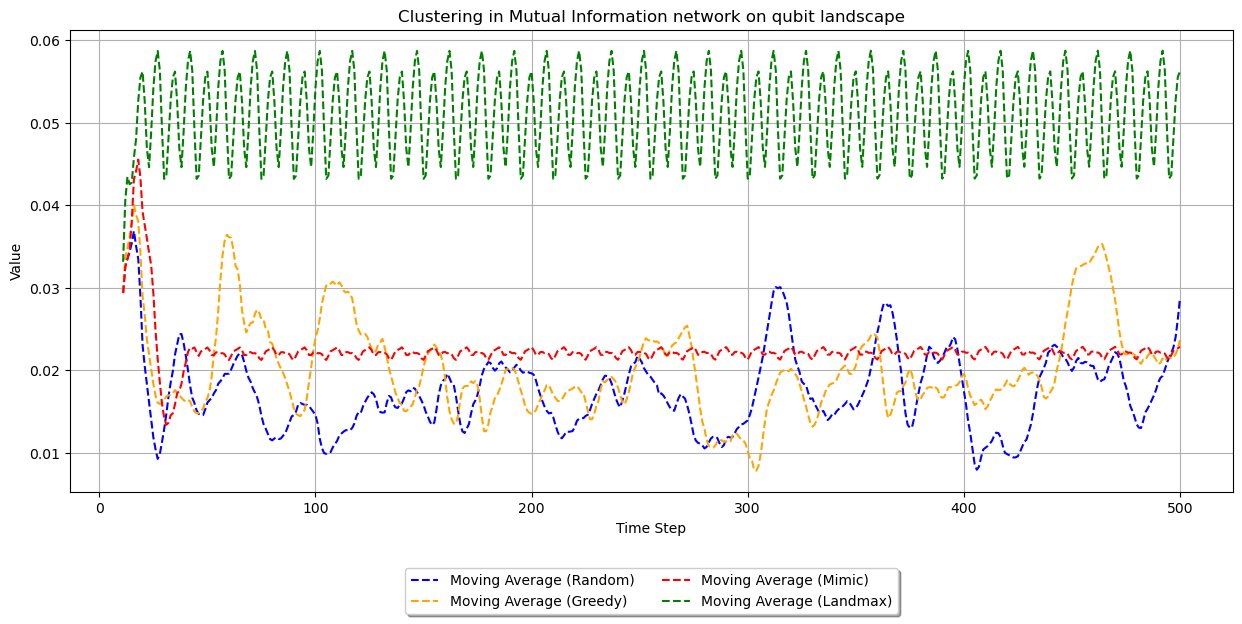

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_33699/1734428674.py:21: RuntimeWarning: invalid value encountered in divide
  Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)


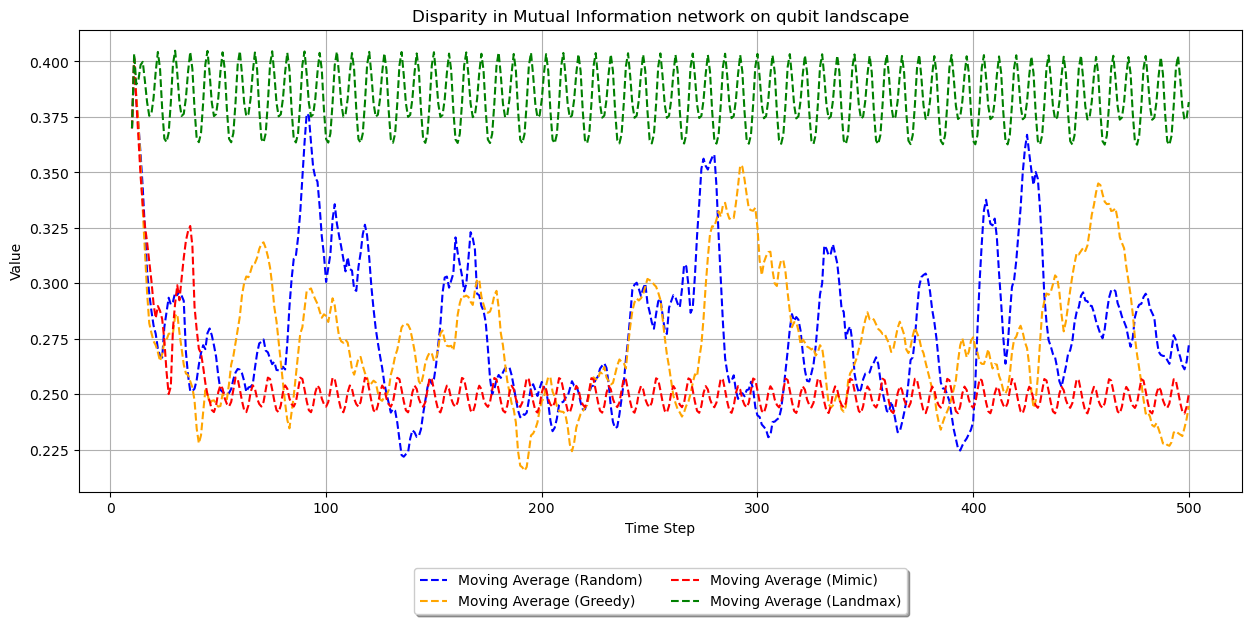

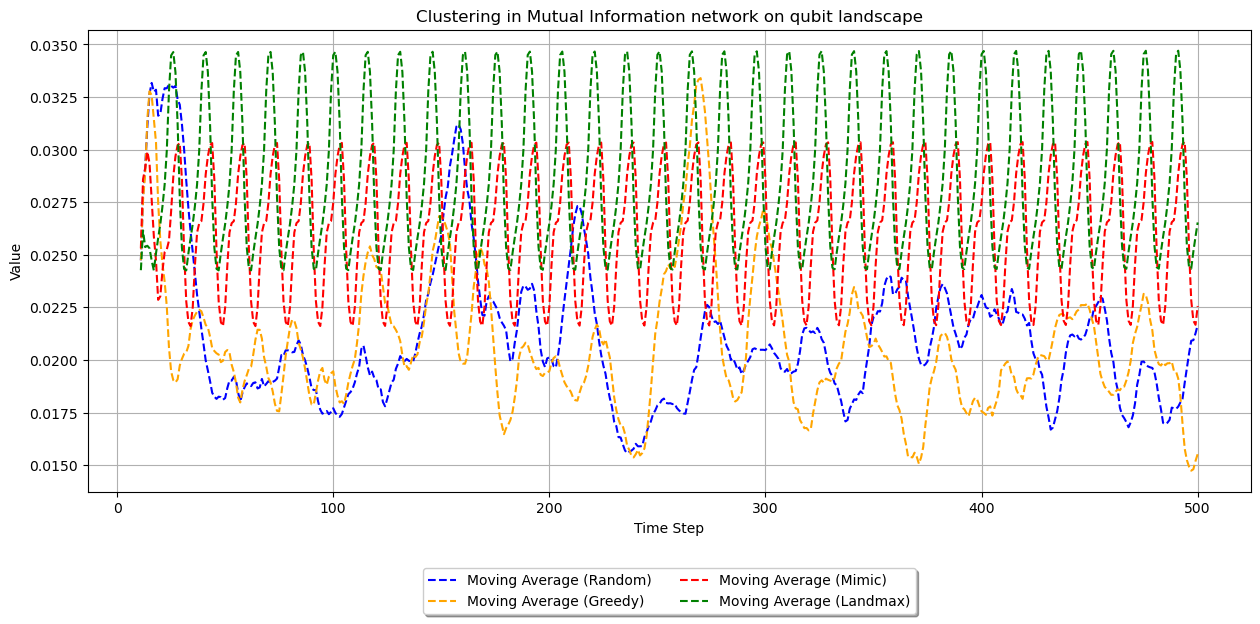

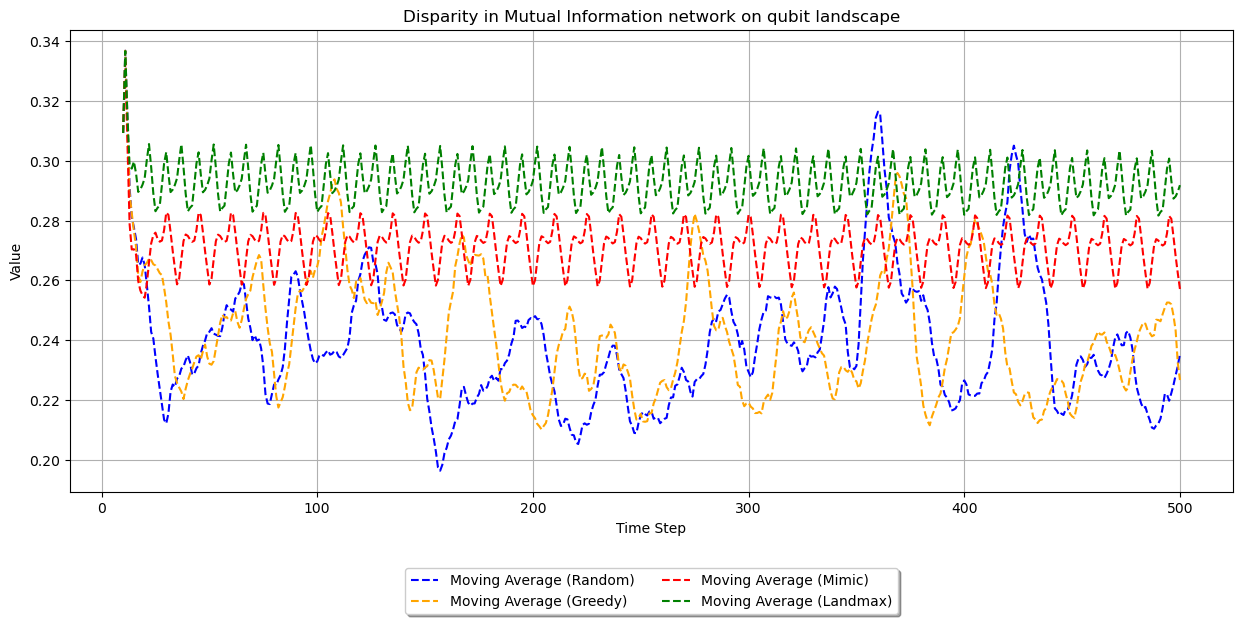

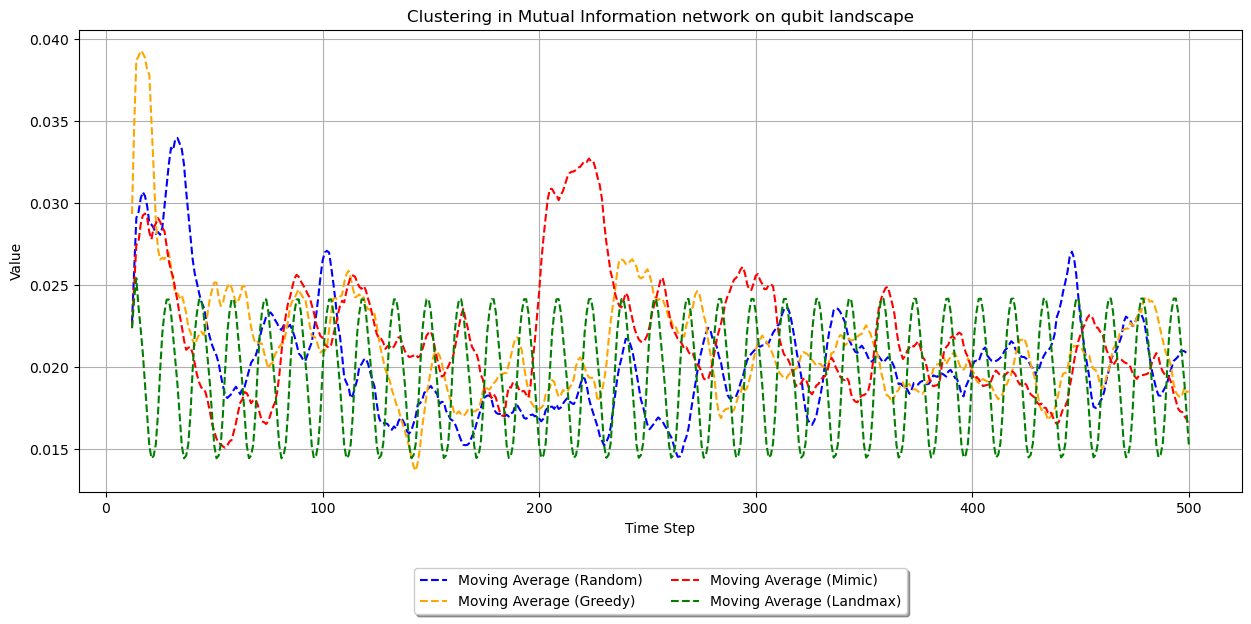

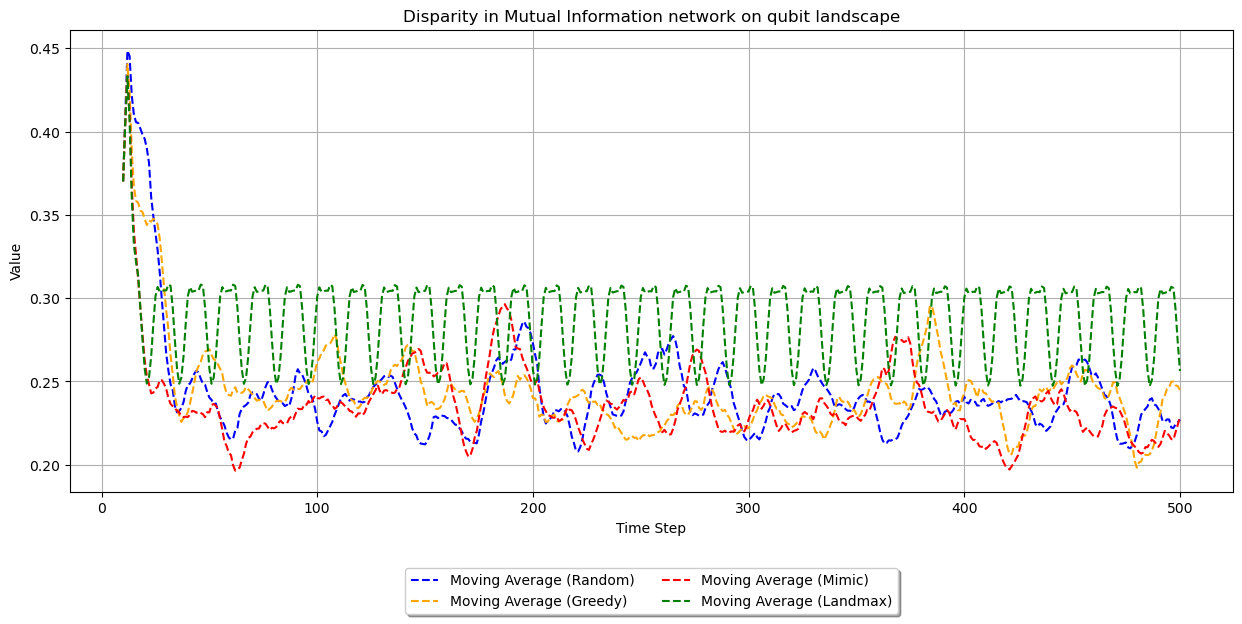

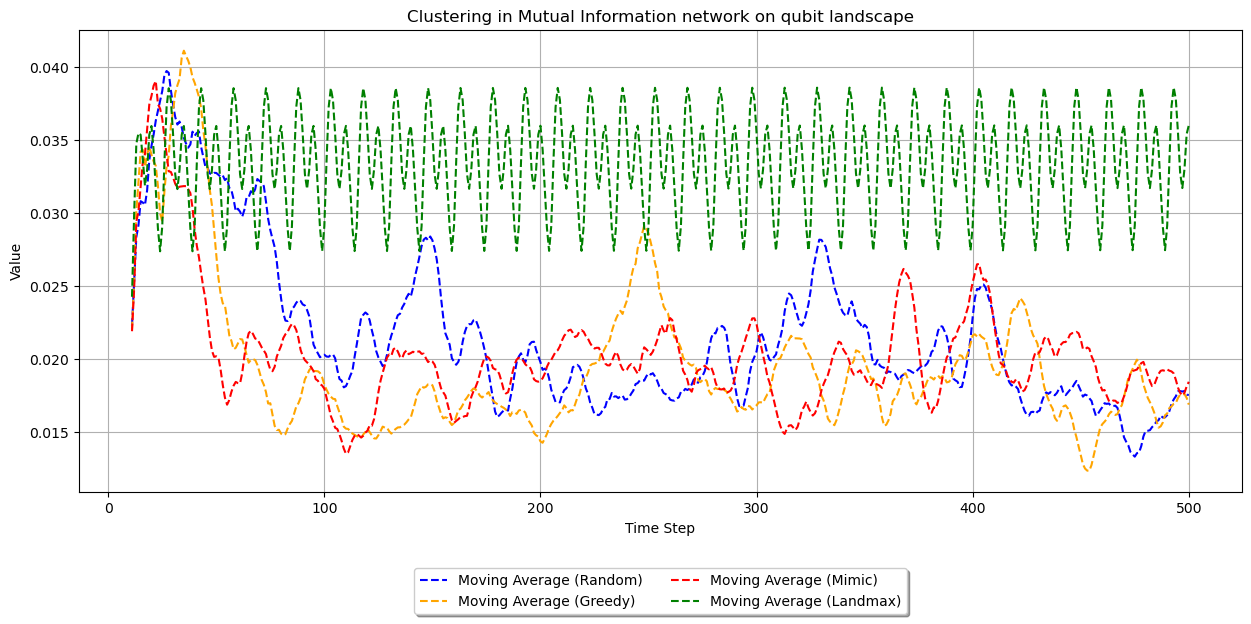

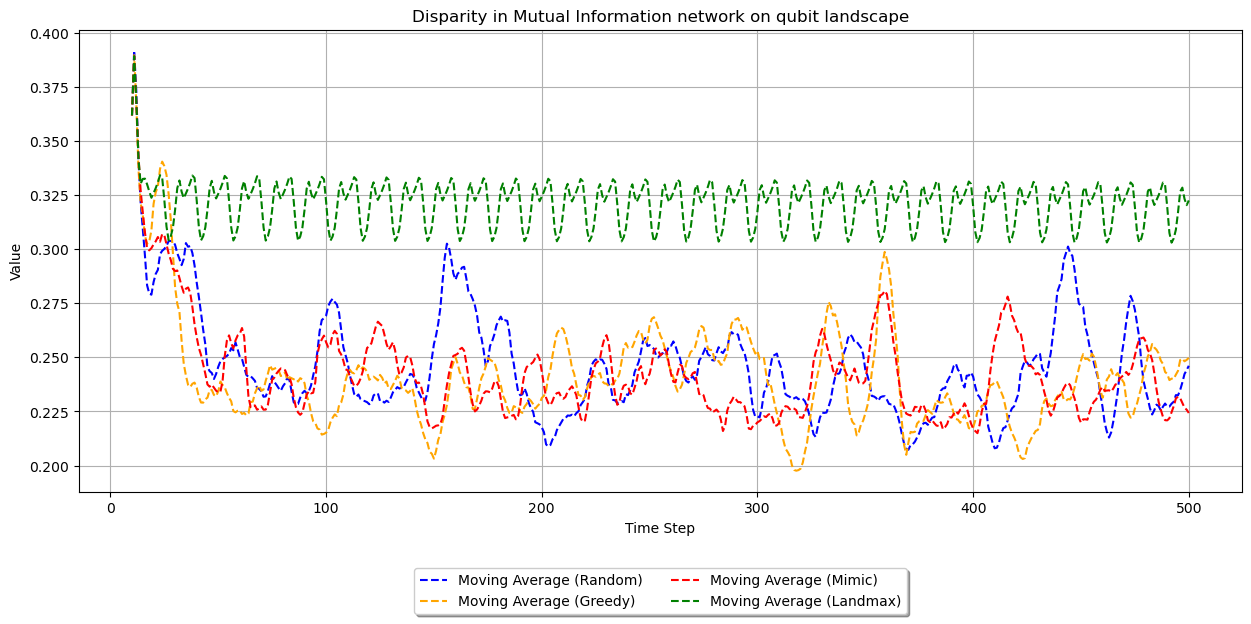

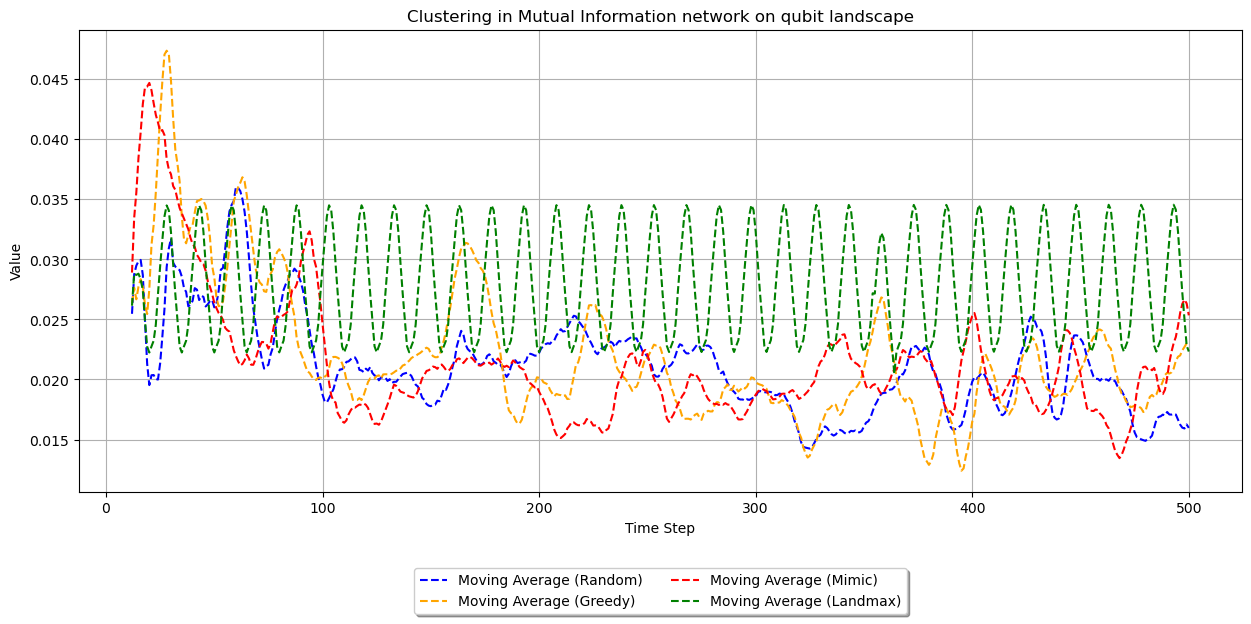

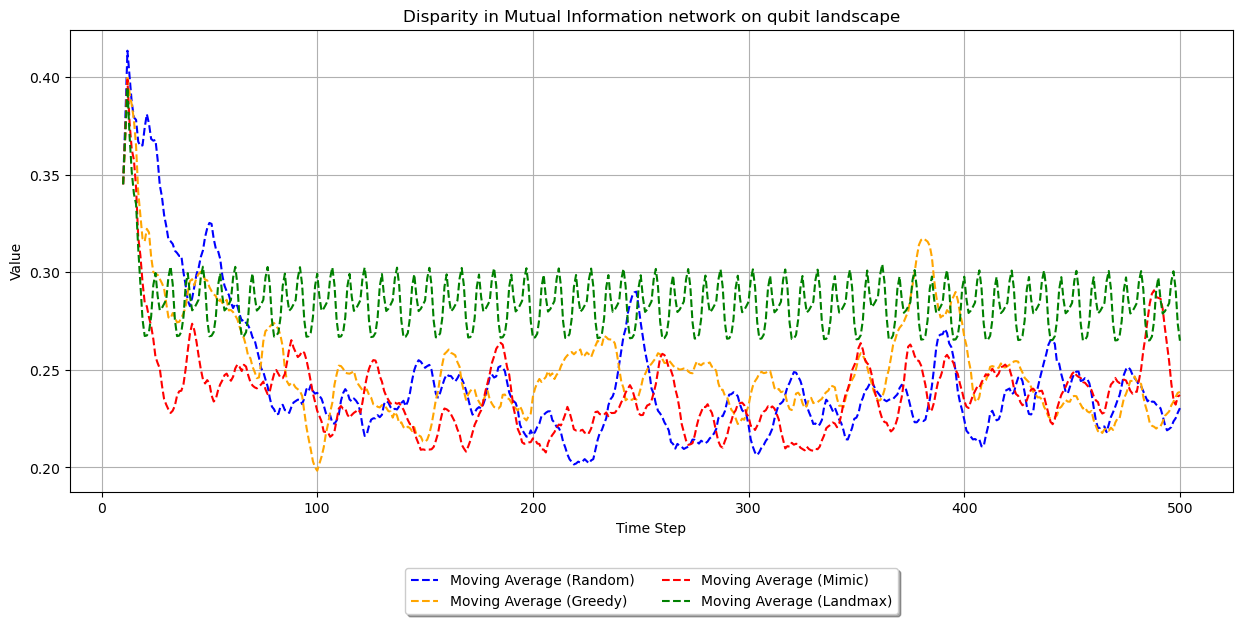

In [15]:
num_nodes=8
list_conn = ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]
for conn in list_conn:
    twoQdmsrandom = get_2_qbit_dms(newdata1,8,conn,"random")
    twoQdmsgreedy = get_2_qbit_dms(newdata2,8,conn,"greedy")
    twoQdmslandmax = get_2_qbit_dms(newdata4,8,conn,"landscape_maximizes")
    twoQdmsmimic = get_2_qbit_dms(newdata3,8,conn,"mimic")
    #twoQdmsweakmax = get_2_qbit_dms(newdata5,8,"c5","weakest_maximizes")

    adj_matrices_list_greedy = adjacency_matrices_list_two_dim(twoQdmsgreedy,0, num_nodes,mutual_info_dicts)
    adj_matrices_list_random = adjacency_matrices_list_two_dim(twoQdmsrandom,0, num_nodes,mutual_info_dicts)
    adj_matrices_list_landmax = adjacency_matrices_list_two_dim(twoQdmslandmax,0, num_nodes,mutual_info_dicts)
    adj_matrices_list_mimic = adjacency_matrices_list_two_dim(twoQdmsmimic,0, num_nodes,mutual_info_dicts)
    #C5
    clustering_greedy = clustering_coeff_function_of_time(np.array(adj_matrices_list_greedy))
    clustering_random = clustering_coeff_function_of_time(np.array(adj_matrices_list_random))
    clustering_landmax = clustering_coeff_function_of_time(np.array(adj_matrices_list_landmax))
    clustering_mimic= clustering_coeff_function_of_time(np.array(adj_matrices_list_mimic))
    print()
    #plot_four_stats_as_function_of_time(clustering_random,clustering_greedy, clustering_landmax,clustering_mimic, filename='clustering_c5_temp_var',title = 'Clustering in Mutual Information network on qubit landscape')
    #plt.show()
    plot_four_stats_as_function_of_time_avg(clustering_random,clustering_greedy, clustering_mimic,clustering_landmax, filename='clustering_c5_temp_var',title = 'Clustering in Mutual Information network on qubit landscape')
    plt.show()
    
    #C5
    disparity_greedy = disparity_function_of_time(np.array(adj_matrices_list_greedy),8)
    disparity_random = disparity_function_of_time(np.array(adj_matrices_list_random),8)
    disparity_landmax = disparity_function_of_time(np.array(adj_matrices_list_landmax),8)
    disparity_mimic = disparity_function_of_time(np.array(adj_matrices_list_mimic),8)
    #plot_four_stats_as_function_of_time(disparity_random,disparity_greedy, disparity_landmax,disparity_mimic, filename='disparity_c5_temp_var',title = 'Disparity in Mutual Information network on qubit landscape')
    #plt.show()
    plot_four_stats_as_function_of_time_avg(disparity_random,disparity_greedy, disparity_mimic,disparity_landmax, filename='disparity_c5_temp_var_avg',title = 'Disparity in Mutual Information network on qubit landscape')
    plt.show()

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_33699/1734428674.py:11: RuntimeWarning: invalid value encountered in scalar divide
  C_list.append(M_cube_trace/sum_of_M_sq)


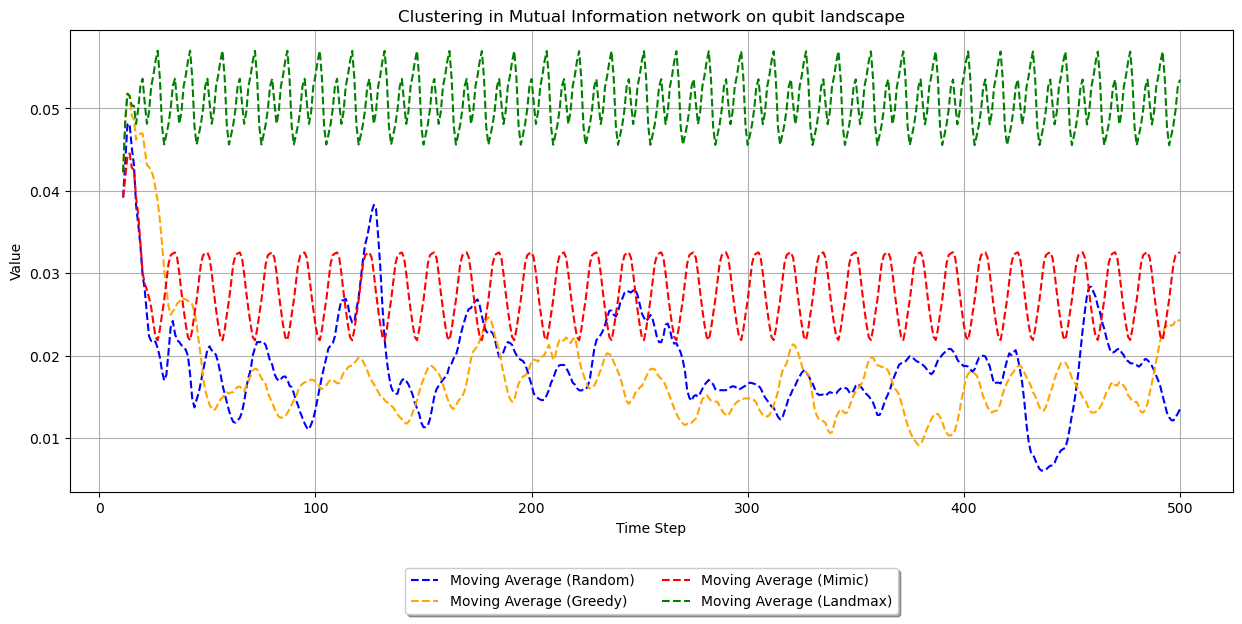

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_33699/1734428674.py:21: RuntimeWarning: invalid value encountered in divide
  Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)


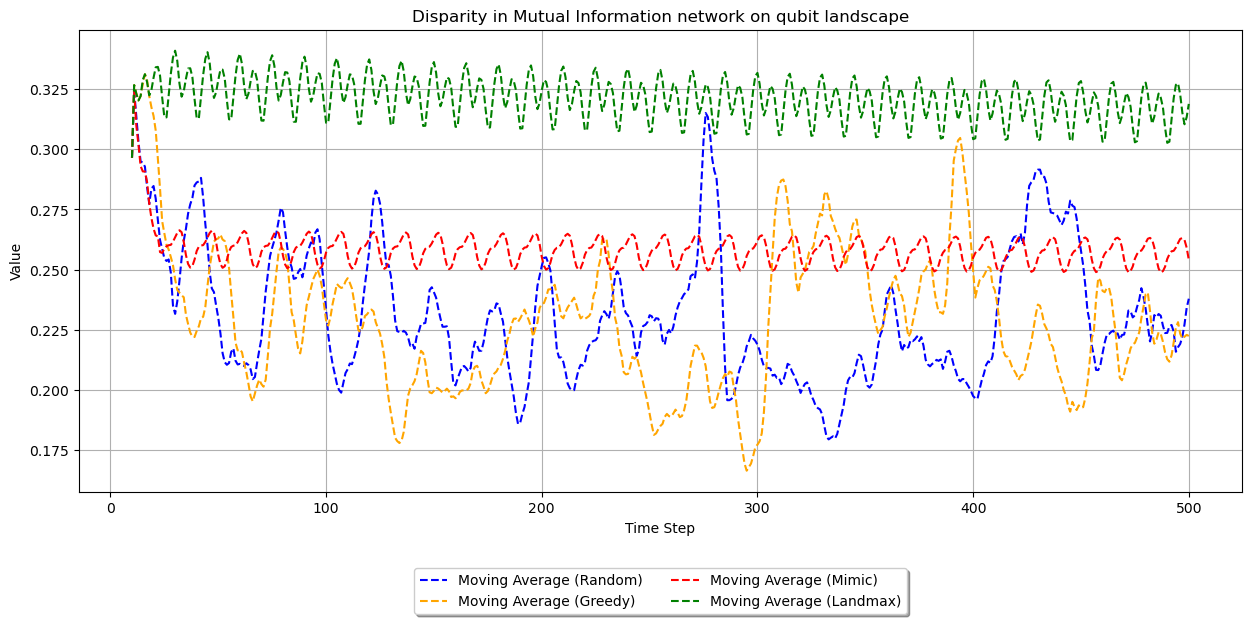

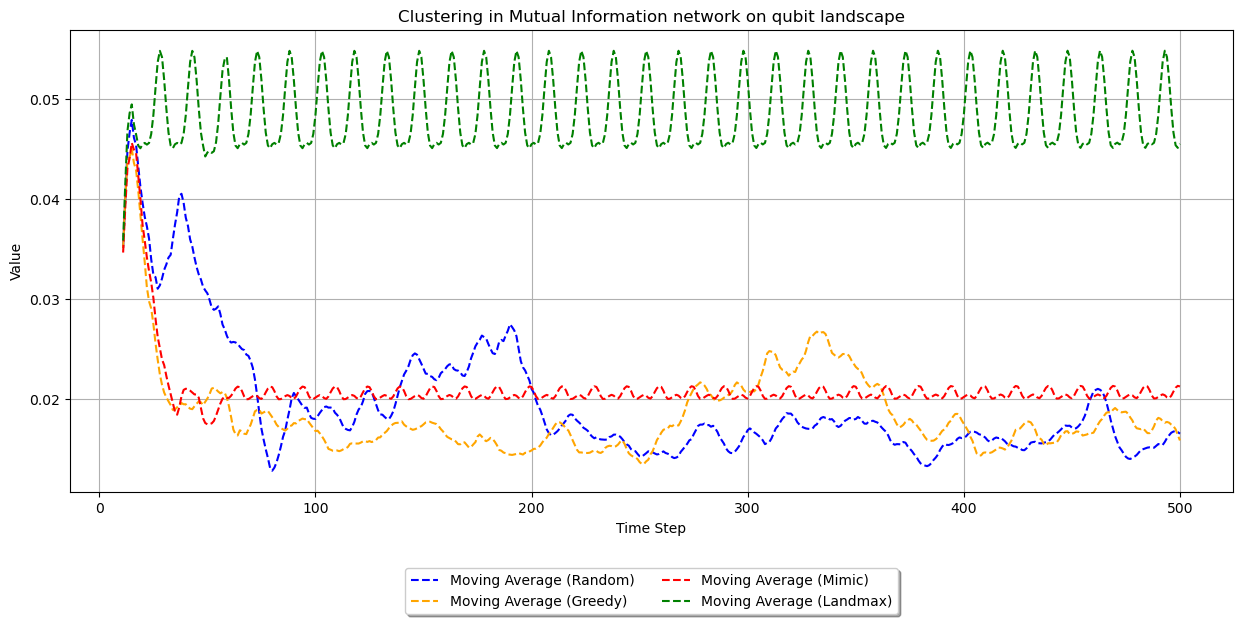

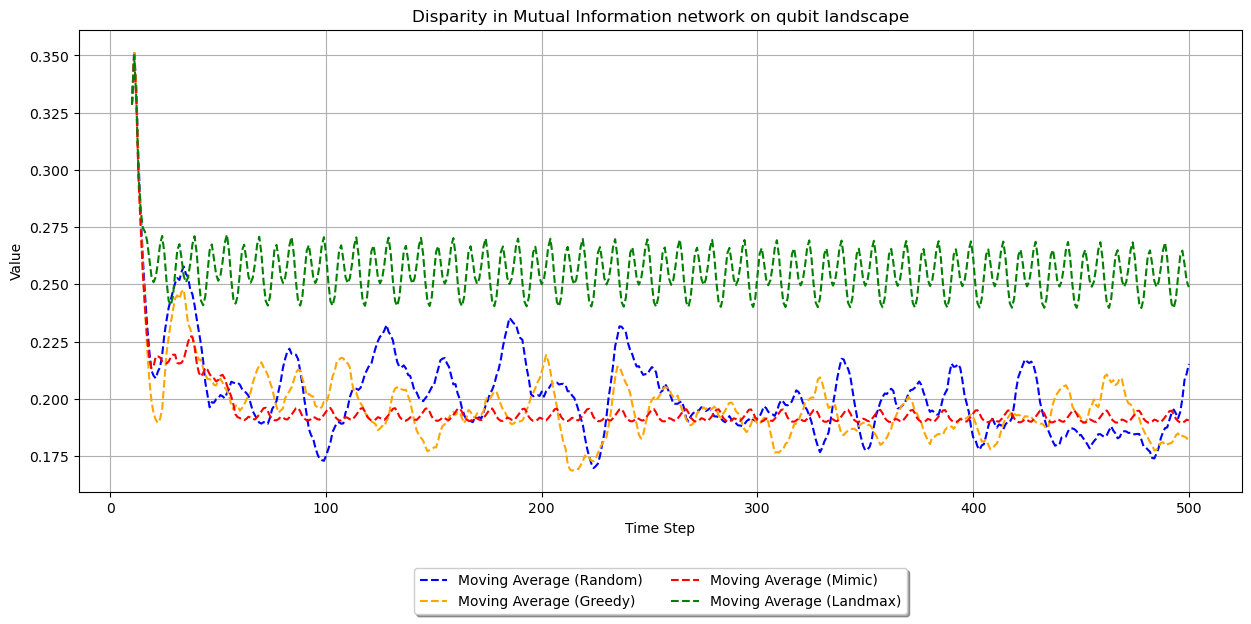

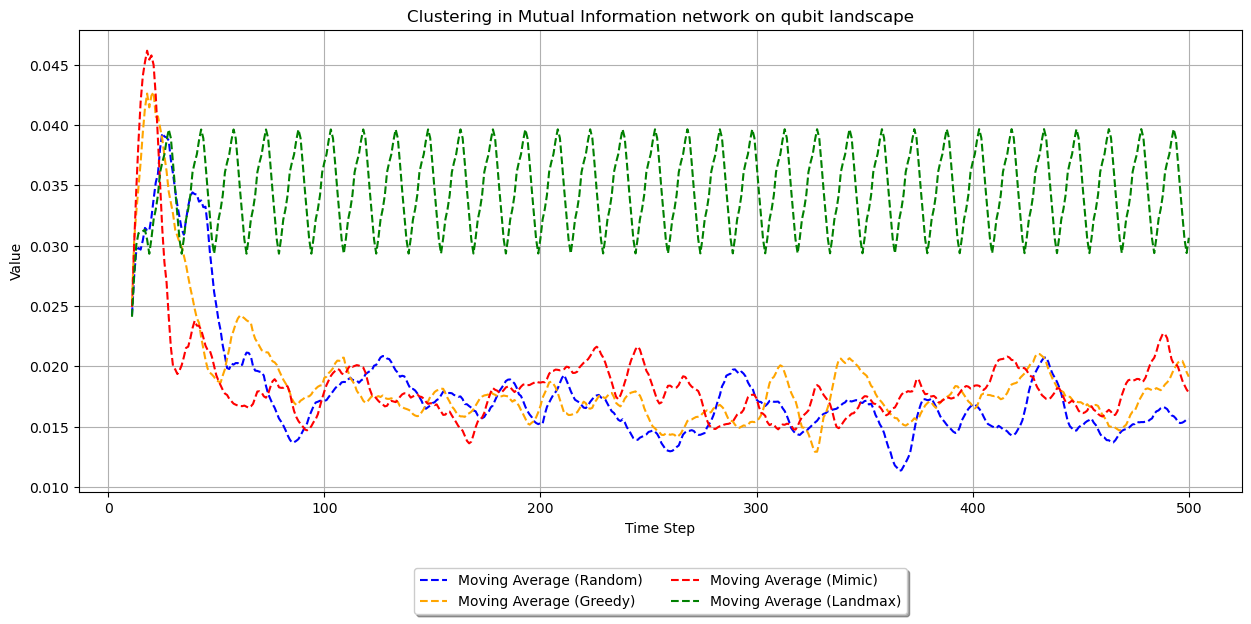

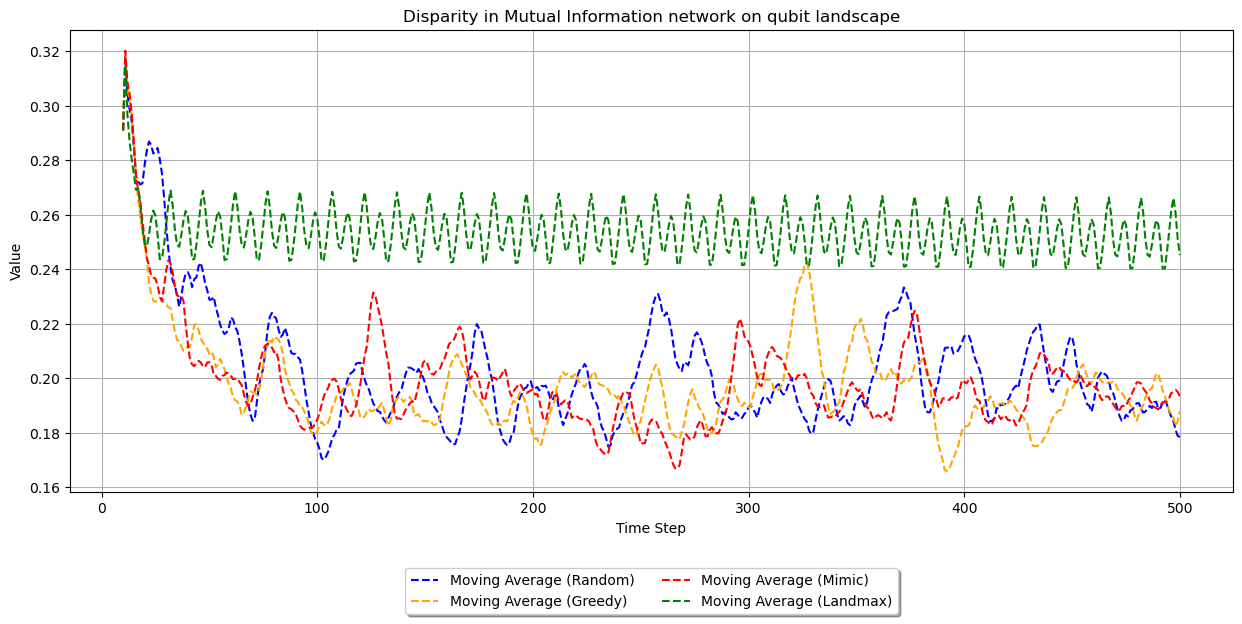

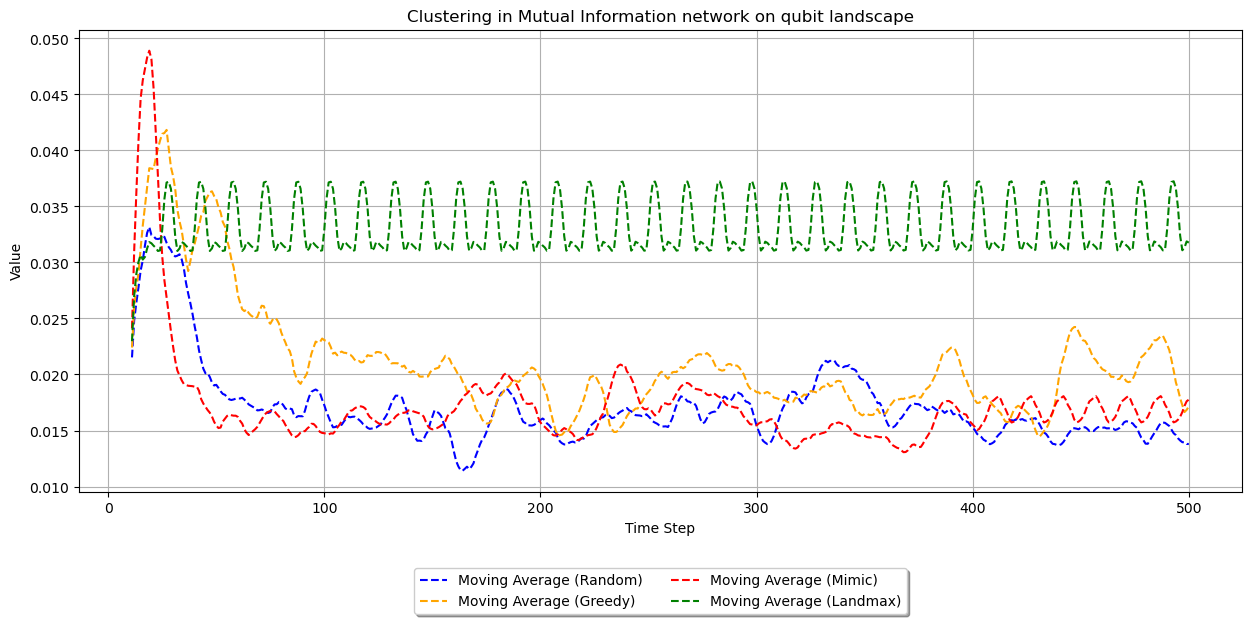

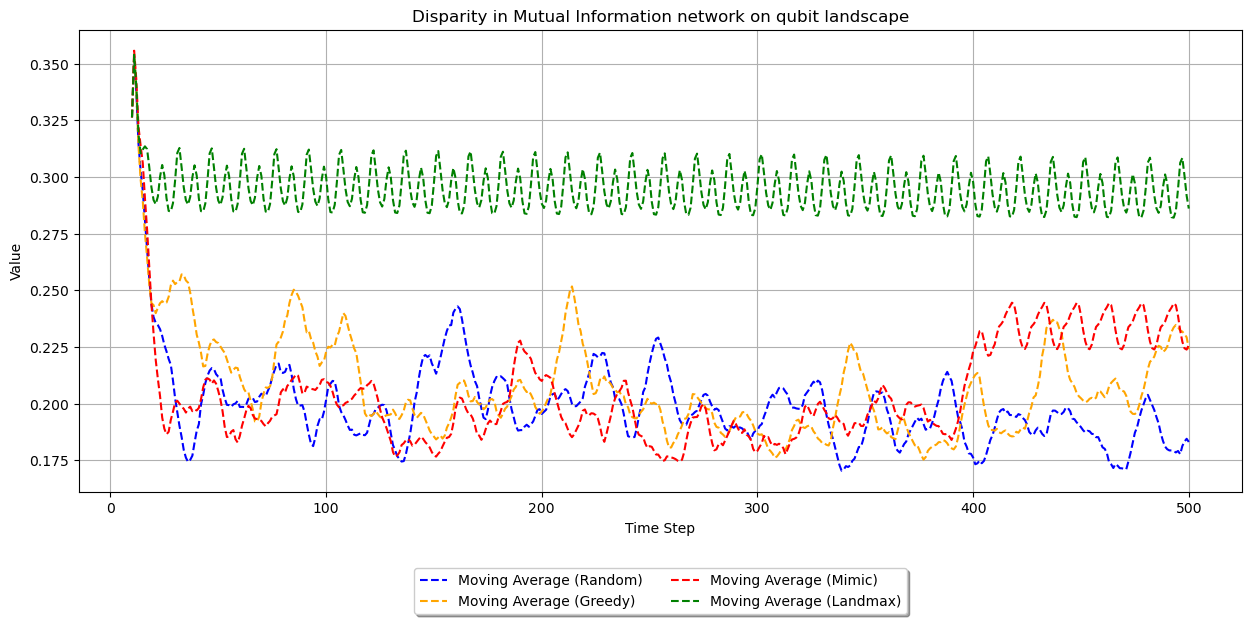

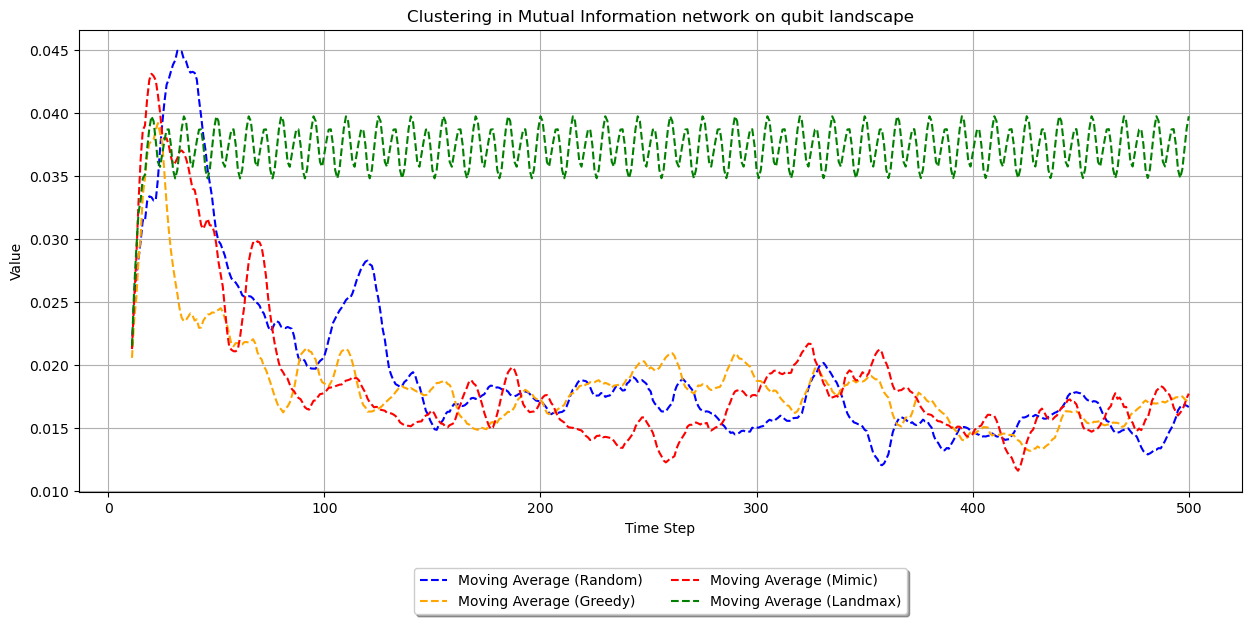

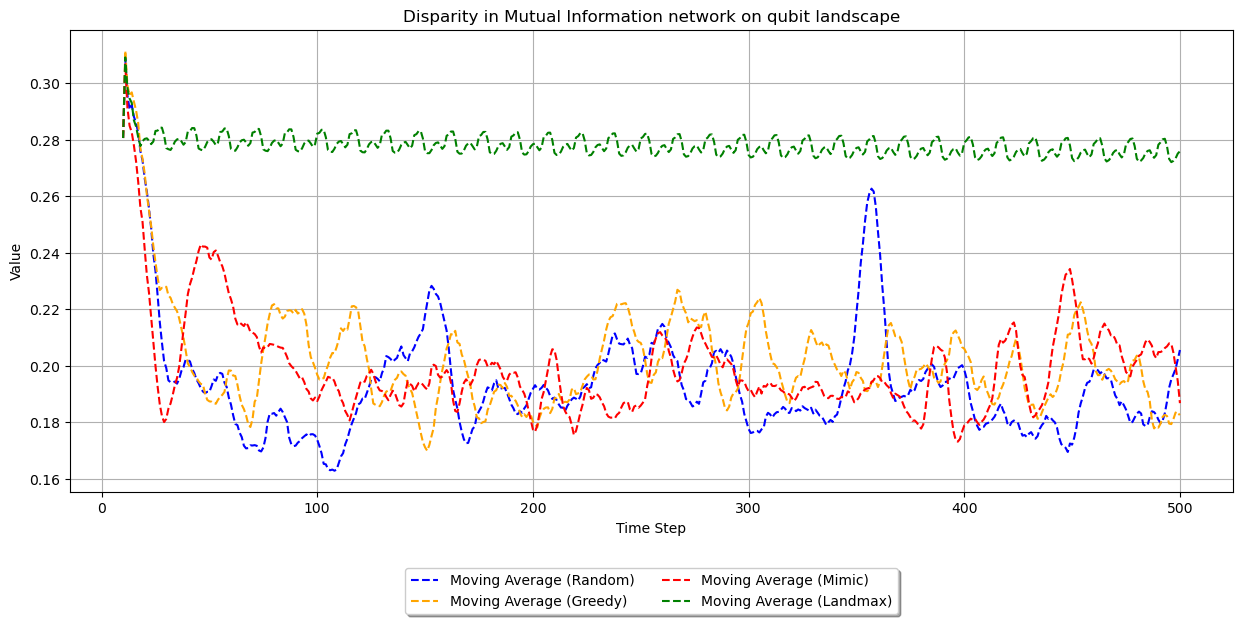

In [18]:
num_nodes=10
list_conn = ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]
for conn in list_conn:
    twoQdmsrandom = get_2_qbit_dms(newdata1,num_nodes,conn,"random")
    twoQdmsgreedy = get_2_qbit_dms(newdata2,num_nodes,conn,"greedy")
    twoQdmslandmax = get_2_qbit_dms(newdata4,num_nodes,conn,"landscape_maximizes")
    twoQdmsmimic = get_2_qbit_dms(newdata3,num_nodes,conn,"mimic")
    #twoQdmsweakmax = get_2_qbit_dms(newdata5,8,"c5","weakest_maximizes")

    adj_matrices_list_greedy = adjacency_matrices_list_two_dim(twoQdmsgreedy,0, num_nodes,mutual_info_dicts)
    adj_matrices_list_random = adjacency_matrices_list_two_dim(twoQdmsrandom,0, num_nodes,mutual_info_dicts)
    adj_matrices_list_landmax = adjacency_matrices_list_two_dim(twoQdmslandmax,0, num_nodes,mutual_info_dicts)
    adj_matrices_list_mimic = adjacency_matrices_list_two_dim(twoQdmsmimic,0, num_nodes,mutual_info_dicts)
    #C5
    clustering_greedy = clustering_coeff_function_of_time(np.array(adj_matrices_list_greedy))
    clustering_random = clustering_coeff_function_of_time(np.array(adj_matrices_list_random))
    clustering_landmax = clustering_coeff_function_of_time(np.array(adj_matrices_list_landmax))
    clustering_mimic= clustering_coeff_function_of_time(np.array(adj_matrices_list_mimic))
    print()
    #plot_four_stats_as_function_of_time(clustering_random,clustering_greedy, clustering_landmax,clustering_mimic, filename='clustering_c5_temp_var',title = 'Clustering in Mutual Information network on qubit landscape')
    #plt.show()
    plot_four_stats_as_function_of_time_avg(clustering_random,clustering_greedy, clustering_mimic,clustering_landmax, filename='clustering_c5_temp_var',title = 'Clustering in Mutual Information network on qubit landscape')
    plt.show()
    
    #C5
    disparity_greedy = disparity_function_of_time(np.array(adj_matrices_list_greedy),num_nodes)
    disparity_random = disparity_function_of_time(np.array(adj_matrices_list_random),num_nodes)
    disparity_landmax = disparity_function_of_time(np.array(adj_matrices_list_landmax),num_nodes)
    disparity_mimic = disparity_function_of_time(np.array(adj_matrices_list_mimic),num_nodes)
    #plot_four_stats_as_function_of_time(disparity_random,disparity_greedy, disparity_landmax,disparity_mimic, filename='disparity_c5_temp_var',title = 'Disparity in Mutual Information network on qubit landscape')
    #plt.show()
    plot_four_stats_as_function_of_time_avg(disparity_random,disparity_greedy, disparity_mimic,disparity_landmax, filename='disparity_c5_temp_var_avg',title = 'Disparity in Mutual Information network on qubit landscape')
    plt.show()

In [11]:
def pearsons_coeeficient_ij_function_time(adjacency_matrix_list,i,j):
    PC_list = []
    #adjacency_matrix_list=np.array(adjacency_matrix_list)
    for adj_mat in adjacency_matrix_list:
        adj_mat=np.array(adj_mat)
        M_avg_i = np.mean(adj_mat[i])
        M_avg_j = np.mean(adj_mat[j])
        Mik_sub_Mi_avg = [x - M_avg_i for x in adj_mat[i]]
        Mjk_sub_Mj_avg = [x - M_avg_j for x in adj_mat[j]]
        Num = np.sum([a * b for a, b in zip(Mik_sub_Mi_avg, Mjk_sub_Mj_avg)])
        Denom1 = np.sqrt((np.sum([y ** 2 for y in Mik_sub_Mi_avg])))
        Denom2 = np.sqrt((np.sum([y ** 2 for y in Mjk_sub_Mj_avg])))
        Denom=Denom1*Denom2
        PC_list.append(Num/Denom)
    return(PC_list)

In [12]:
def pearsons_coeeficient_ij(adjacency_matrix,i,j):
    adj_mat=np.array(adjacency_matrix)
    M_avg_i = np.mean(adj_mat[i])
    M_avg_j = np.mean(adj_mat[j])
    Mik_sub_Mi_avg = [x - M_avg_i for x in adj_mat[i]]
    Mjk_sub_Mj_avg = [x - M_avg_j for x in adj_mat[j]]
    Num = np.sum([a * b for a, b in zip(Mik_sub_Mi_avg, Mjk_sub_Mj_avg)])
    Denom1 = np.sqrt((np.sum([y ** 2 for y in Mik_sub_Mi_avg])))
    Denom2 = np.sqrt((np.sum([y ** 2 for y in Mjk_sub_Mj_avg])))
    Denom=Denom1*Denom2
    PC = Num/Denom
    return(PC)

In [25]:
twoQdmsmimic = get_2_qbit_dms(newdata3,8,"c4_2local","mimic")
    #twoQdmsweakmax = get_2_qbit_dms(newdata5,8,"c5","weakest_maximizes")
adj_matrices_list_mimic = adjacency_matrices_list_two_dim(twoQdmsmimic,0, 8,mutual_info_dicts)

In [28]:
pearsons_coeeficient_ij_function_time(adj_matrices_list_mimic,3,1)

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_33699/1057683138.py:14: RuntimeWarning: invalid value encountered in scalar divide
  PC_list.append(Num/Denom)


[nan,
 nan,
 -0.36413191767552155,
 0.5814584350827309,
 0.6568329940449145,
 0.0741470378781878,
 -0.1518797415886588,
 0.24080166524997115,
 0.012509922149074126,
 -0.2430213308649015,
 -0.3002223379416017,
 -0.09455159117340678,
 0.19407407764630097,
 0.3302883672350728,
 -0.061462627230760056,
 -0.4094442040672664,
 0.5922143032048315,
 0.5398392401337926,
 0.7432274637009497,
 0.4901487233326772,
 0.09792261312980798,
 -0.04480969165130032,
 -0.03643870059500375,
 -0.029689841247291918,
 -0.07000911725185993,
 -0.2353790705292557,
 -0.4328405351201183,
 -0.3288472214171499,
 -0.048938020088659905,
 -0.024929416212703965,
 -0.37887966708167353,
 -0.16516247069508694,
 0.5397835047576662,
 0.7432528745798929,
 0.4902037999383749,
 0.09796754634677482,
 -0.04480615494223405,
 -0.03644317758475308,
 -0.029705057885100996,
 -0.07004188971735412,
 -0.23543042052338106,
 -0.43289429342792407,
 -0.3288959305276997,
 -0.048975429535535554,
 -0.024975935315497237,
 -0.37899853689566426,
 -0

In [13]:
def change_in_ex_work(connectivity,update_rule,data,num):
    sizes = [num]
    connectivities = [connectivity]
    temps = ['cold','hot']
    result = {s:{t:{} for t in temps} for s in sizes}
    for size in sizes:
        for connectivity in connectivities:
            pops = get_pops(data,size,connectivity,update_rule)
            extractable_work = np.array([[measure.extractable_work_of_each_qubit_from_pops(p) for p in time_slice ]for time_slice in pops ])
            change_in_ex_work = np.diff(extractable_work,axis = 1)
    return change_in_ex_work

In [14]:
def cal_pearson_for_best_worst_q(change_in,adj_matrix):
    list_PC_bestq_worstq=[]
    for ind in range(len(change_in)) :
        max_value = np.max(change_in[ind])
        min_value = np.min(change_in[ind])
        abs_change=np.abs(max_value-min_value)
        max_index = np.argmax(change_in[ind])
        min_index = np.argmin(change_in[ind])
        list_PC_bestq_worstq.append(pearsons_coeeficient_ij(adj_matrix[ind],max_index,min_index))
    return list_PC_bestq_worstq
        

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_33699/1381565261.py:11: RuntimeWarning: invalid value encountered in scalar divide
  PC = Num/Denom


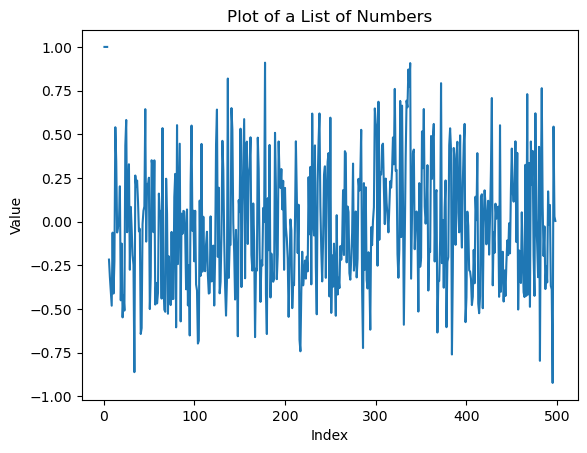

In [82]:
plt.plot(cal_pearson_for_best_worst_q(change_in_ex_work_landmax[0],adj_matrices_list))

# Adding labels
plt.xlabel('Index')
plt.ylabel('Value')

# Adding a title
plt.title('Plot of a List of Numbers')

# Displaying the plot
plt.show()

/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / (np.log((1 - pop) / pop))
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:74: RuntimeWarning: divide by zero encountered in log
  tr_1 = (1 - pop_1) * np.log(1 - pop_1) + (pop_1) * np.log(pop_1)
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:74: RuntimeWarning: invalid value encountered in scalar multiply
  tr_1 = (1 - pop_1) * np.log(1 - pop_1) + (pop_1) * np.log(pop_1)
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:130: RuntimeWarning: divide by zero encountered in log
  from_eigen = -np.sum(eigen_vals * np.log(eigen_vals))
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:130: R

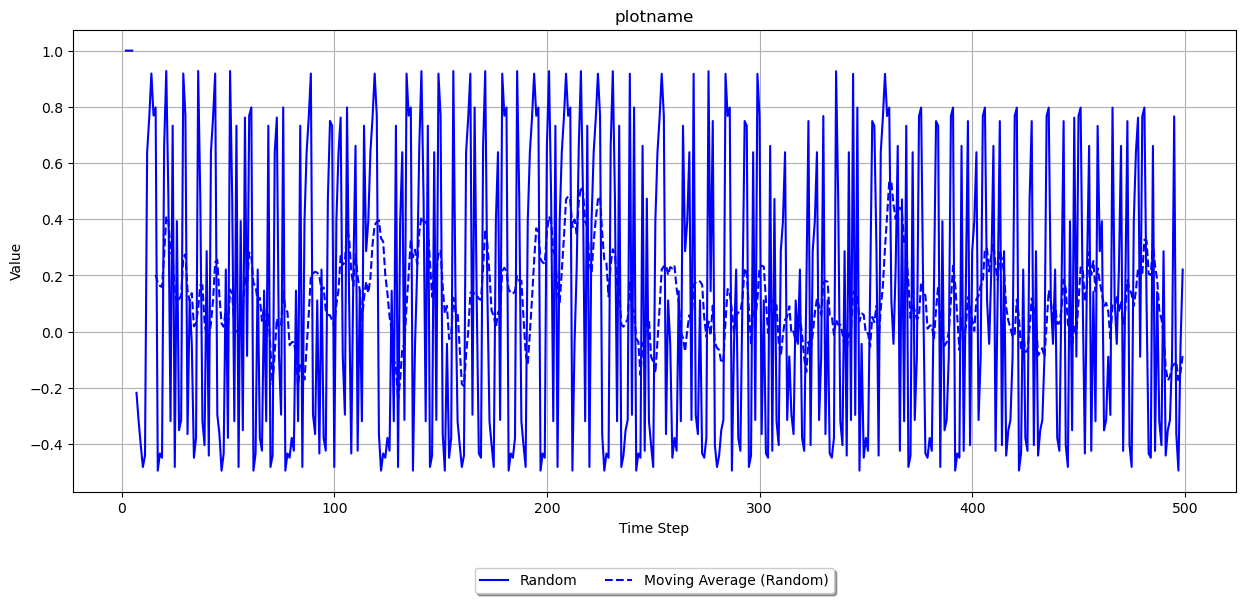

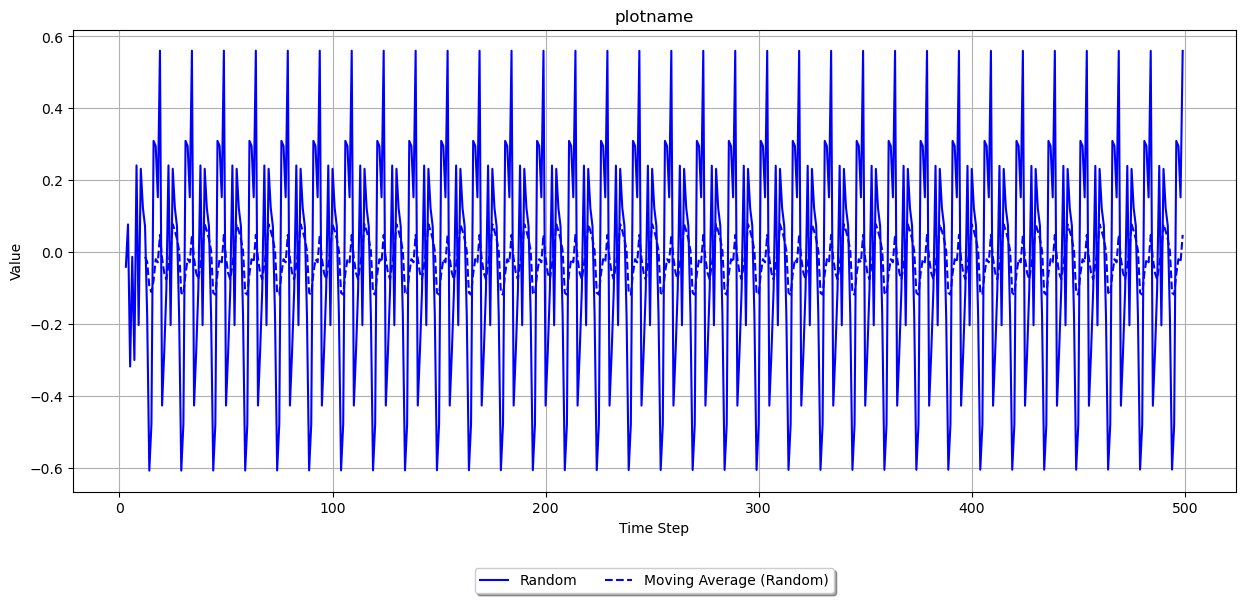

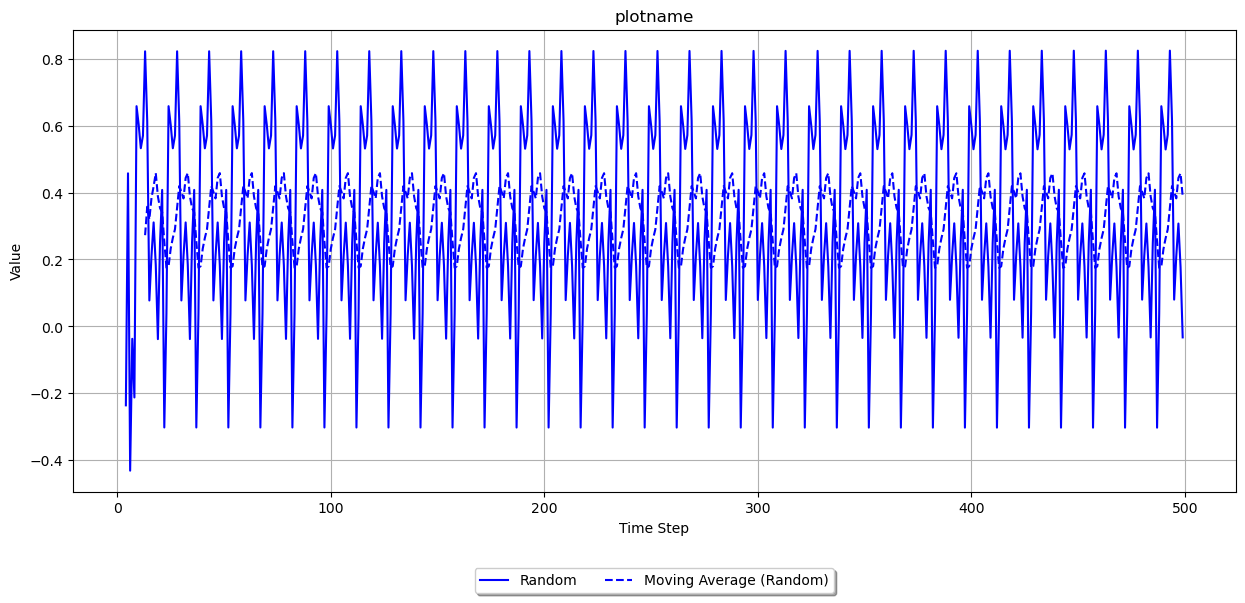

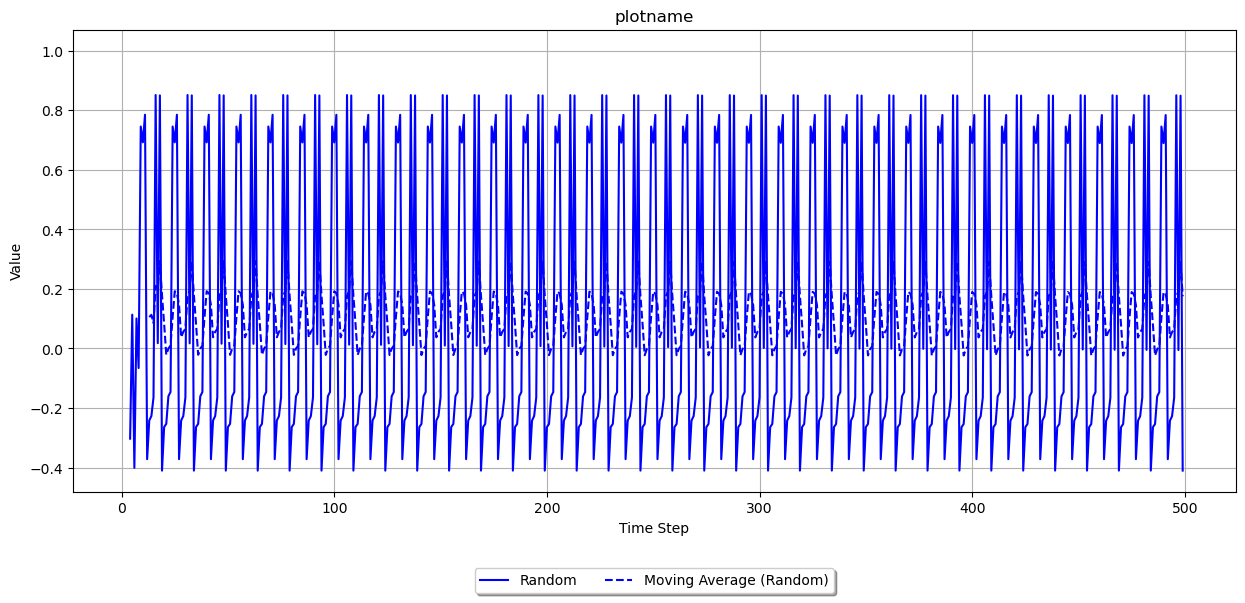

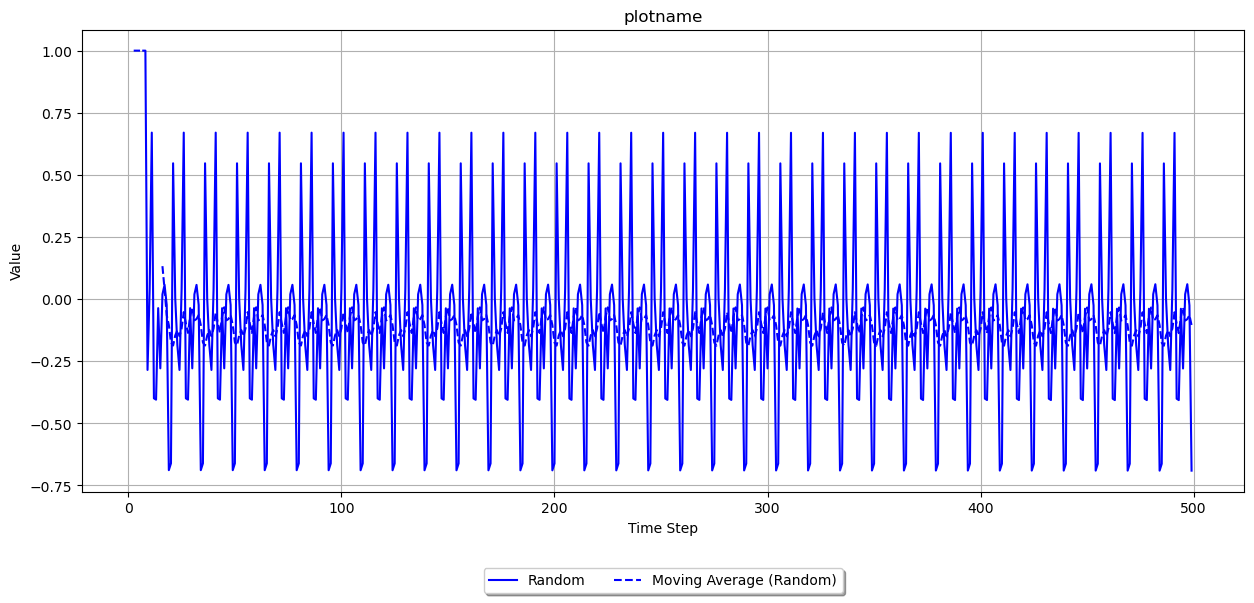

In [19]:
num_nodes=8
list_conn=["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]
for conn in list_conn:
    change_in=change_in_ex_work(conn,"landscape_maximizes",newdata4,num_nodes)
    twoQdm= get_2_qbit_dms(newdata4,num_nodes,conn,"landscape_maximizes")
    adj_matrices_list = adjacency_matrices_list_two_dim(twoQdm,0, num_nodes,mutual_info_dicts)
    plot_one_stats_as_function_of_time(cal_pearson_for_best_worst_q(change_in[0],adj_matrices_list))

In [15]:
def plot_one_stats_as_function_of_time(list1, filename='plot.png',title='plotname'):
    # Assuming both lists have the same length (representing time steps)
    time_steps = range(1, len(list1) + 1)
    
    # Calculate moving averages for both lists
    moving_avg_list1 = moving_average(list1)
    #moving_avg_list2 = moving_average(list2)
    #moving_avg_list3 = moving_average(list3)
   # moving_avg_list4 = moving_average(list4)
    
    # Set the figure size (adjust as needed)
    plt.figure(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches
    
    # Plotting the lists and their moving averages
    plt.plot(time_steps, list1, color='blue', label='Random')
    #plt.plot(time_steps, list2,color='orange', label='Greedy')
    #plt.plot(time_steps, list3, color='red',label='Mimic')
   # plt.plot(time_steps, list4, color='green',label='Landmax')
    plt.plot(time_steps[len(list1) - len(moving_avg_list1):], moving_avg_list1, linestyle='--', color='blue', label='Moving Average (Random)')
    #plt.plot(time_steps[len(list2) - len(moving_avg_list2):], moving_avg_list2, linestyle='--', color='orange', label='Moving Average (Greedy)')
    #plt.plot(time_steps[len(list3) - len(moving_avg_list3):], moving_avg_list3, linestyle='--', color='red', label='Moving Average (Mimic)')
    #plt.plot(time_steps[len(list4) - len(moving_avg_list4):], moving_avg_list4, linestyle='--', color='green', label='Moving Average (Landmax)')    
    
    # Adding labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    
    # Adding legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    
    # Display the plot
    plt.grid(True)
    
    # Save the plot with the desired filename

/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / (np.log((1 - pop) / pop))
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:74: RuntimeWarning: divide by zero encountered in log
  tr_1 = (1 - pop_1) * np.log(1 - pop_1) + (pop_1) * np.log(pop_1)
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:74: RuntimeWarning: invalid value encountered in scalar multiply
  tr_1 = (1 - pop_1) * np.log(1 - pop_1) + (pop_1) * np.log(pop_1)
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:130: RuntimeWarning: divide by zero encountered in log
  from_eigen = -np.sum(eigen_vals * np.log(eigen_vals))
/Users/uja5020/Documents/GitHub/Qnibble/Notebooks/../src/measurements.py:130: R

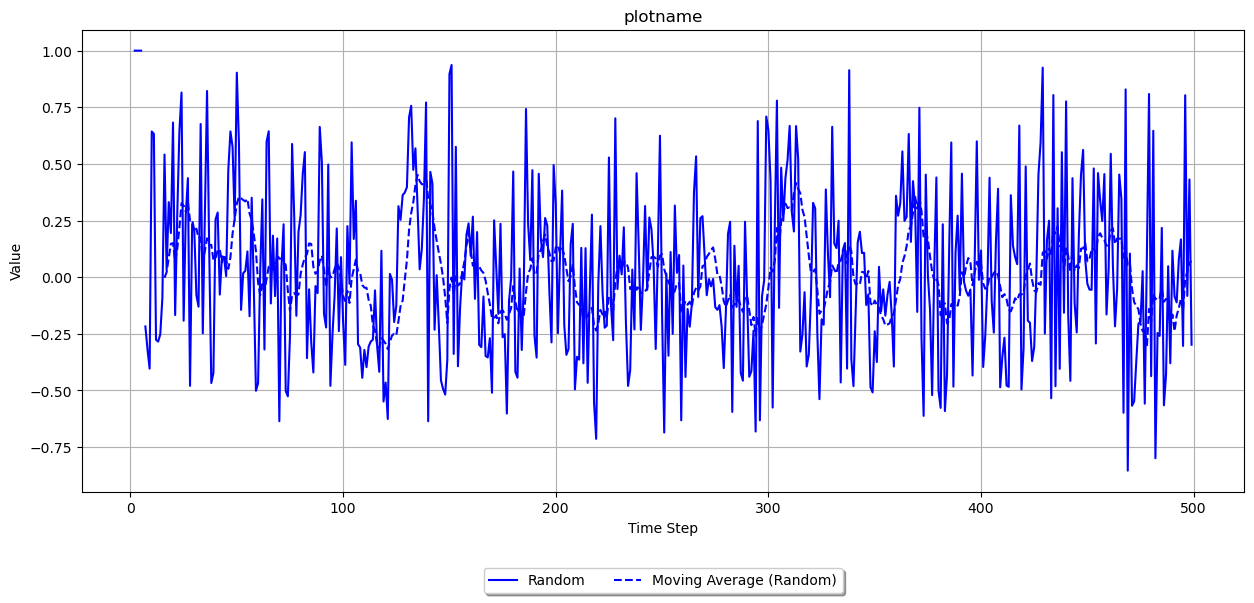

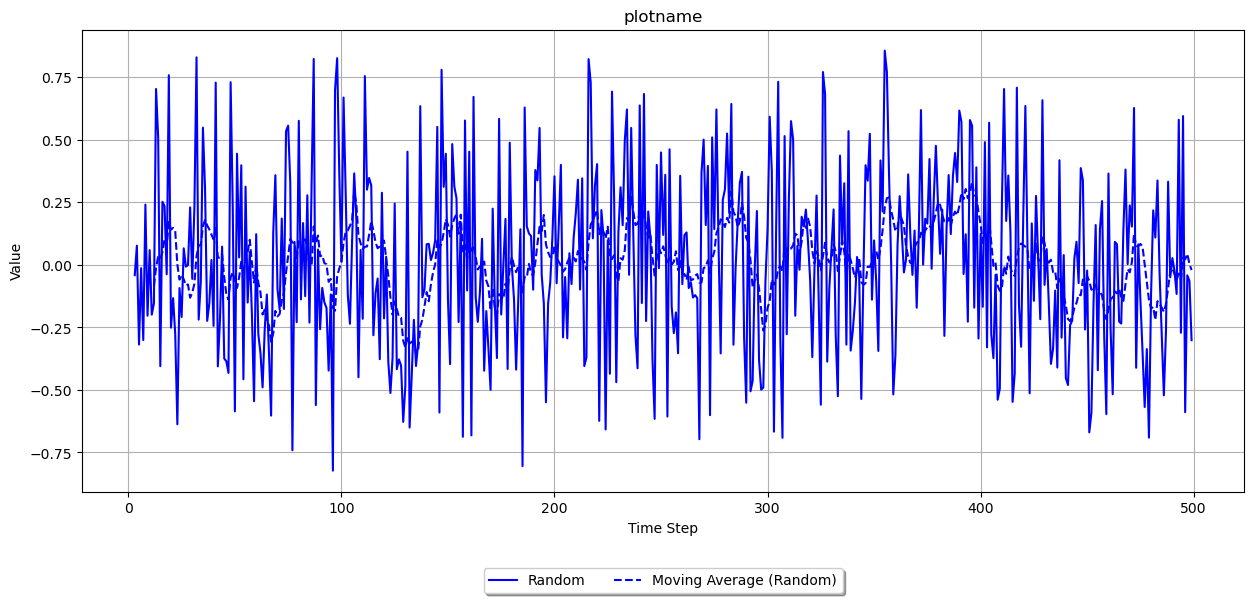

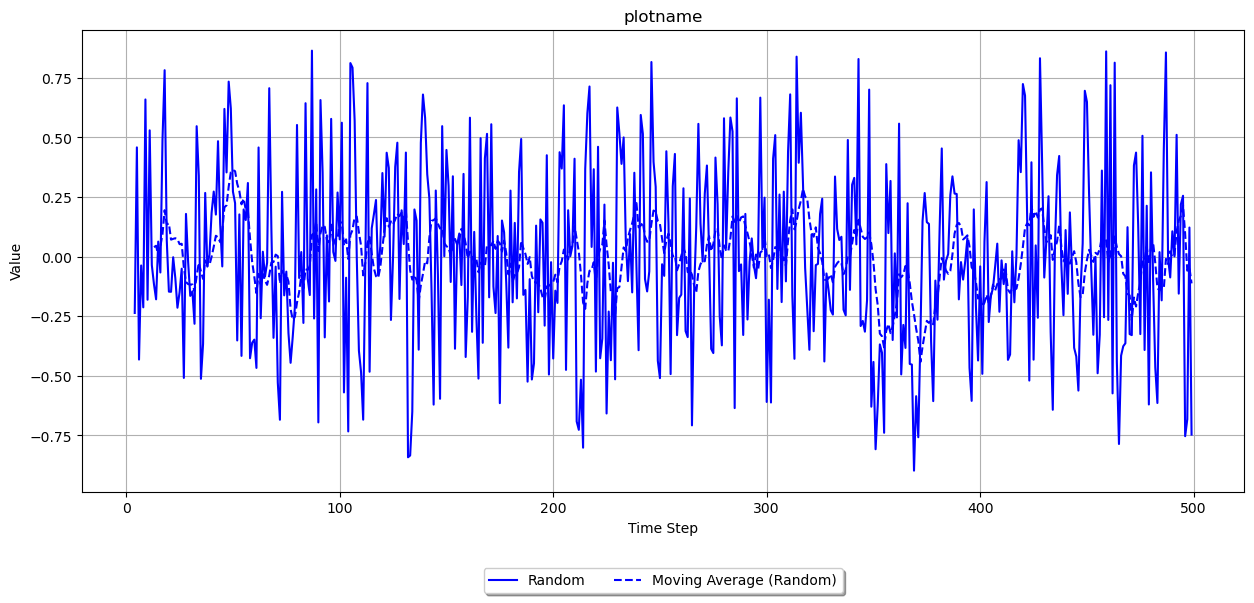

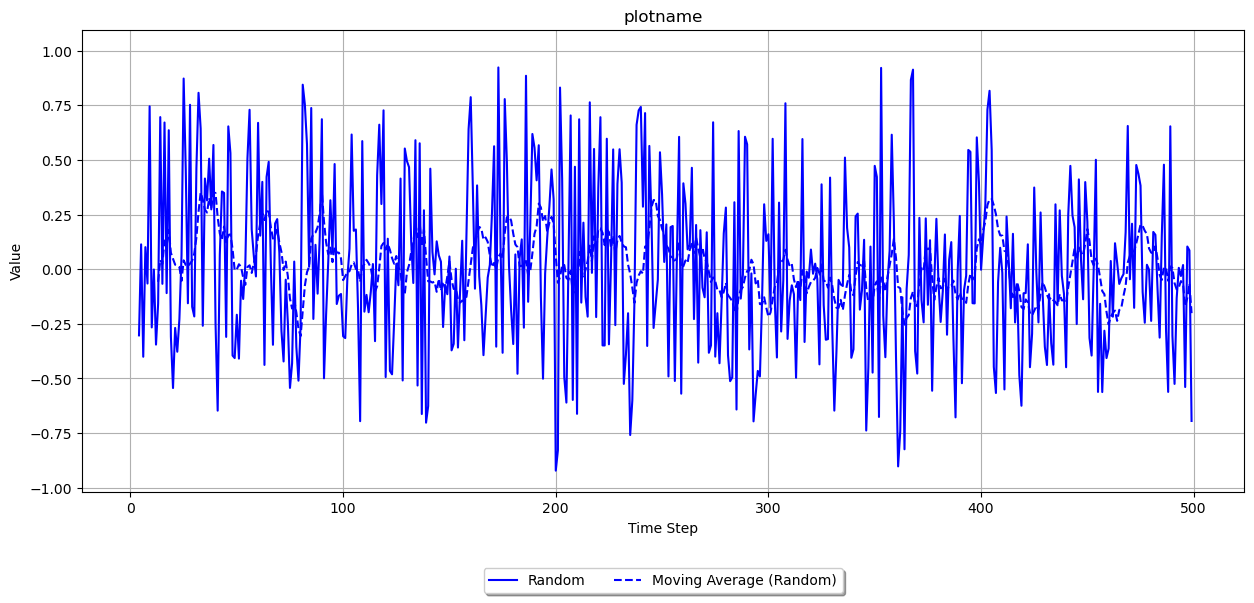

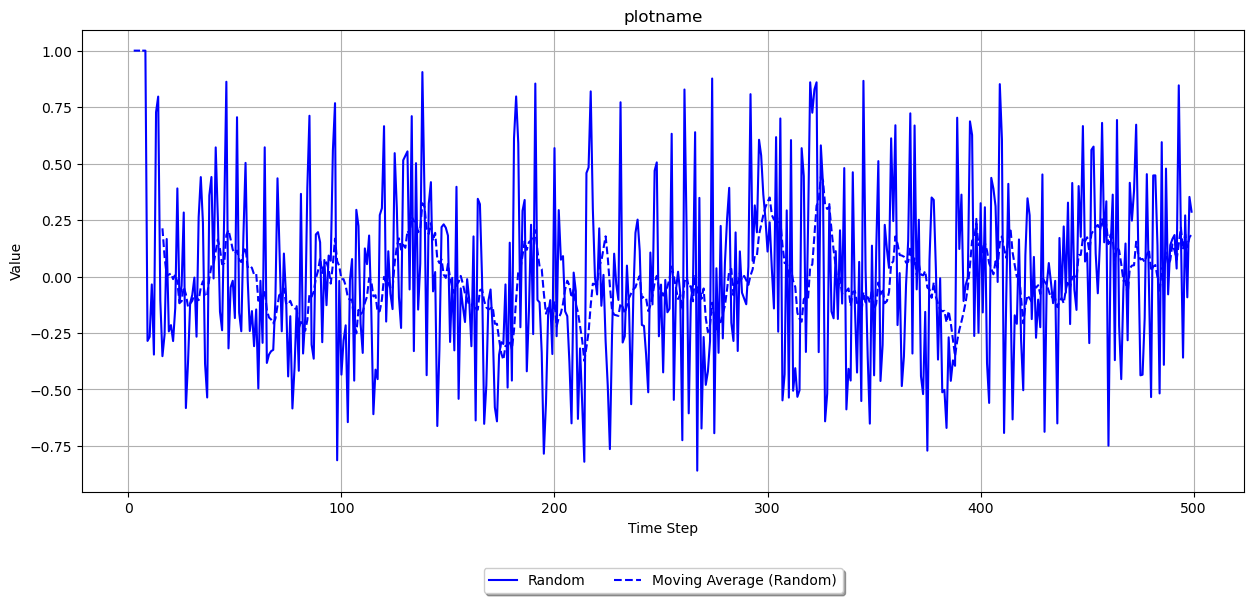

In [16]:
num_nodes=8
for conn in ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]:
    change_in=change_in_ex_work(conn,"random",newdata1,num_nodes)
    twoQdm= get_2_qbit_dms(newdata1,num_nodes,conn,"random")
        #twoQdmsweakmax = get_2_qbit_dms(newdata5,8,"c5","weakest_maximizes")
    adj_matrices_list = adjacency_matrices_list_two_dim(twoQdm,0, num_nodes,mutual_info_dicts)
    plot_one_stats_as_function_of_time(cal_pearson_for_best_worst_q(change_in[0],adj_matrices_list))

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_18712/1381565261.py:11: RuntimeWarning: invalid value encountered in scalar divide
  PC = Num/Denom


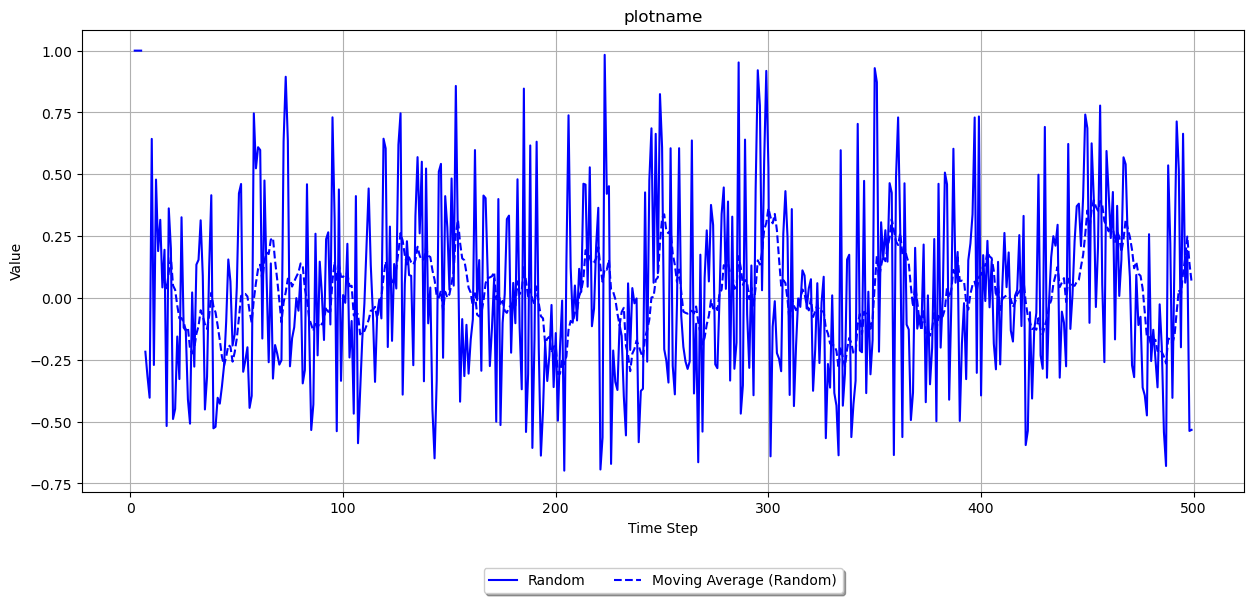

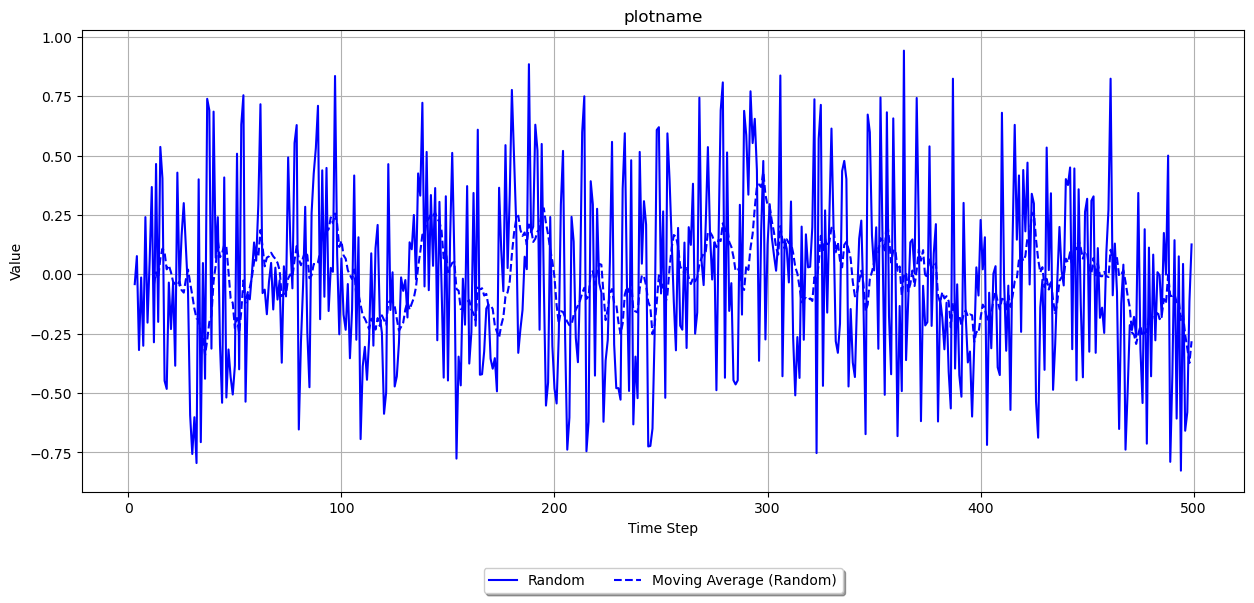

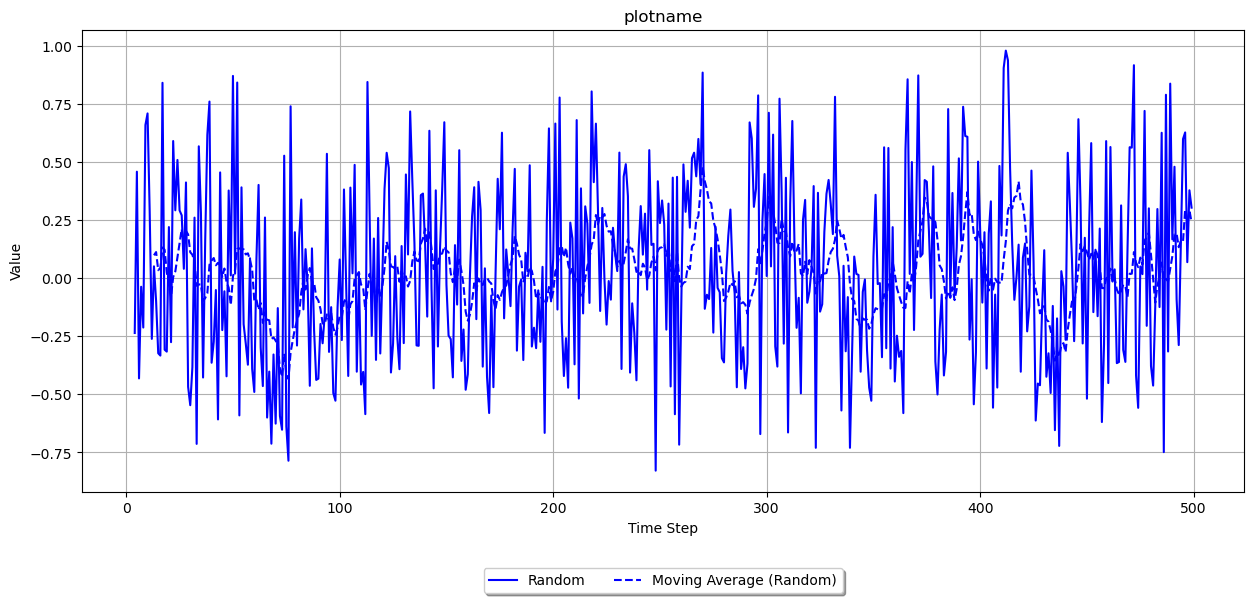

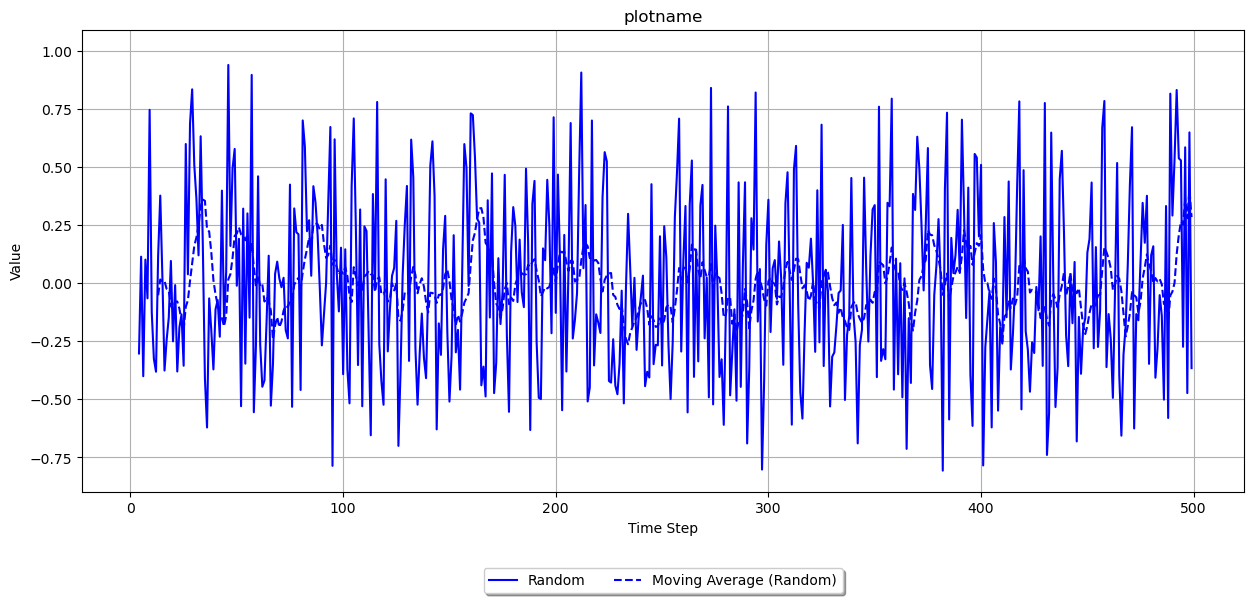

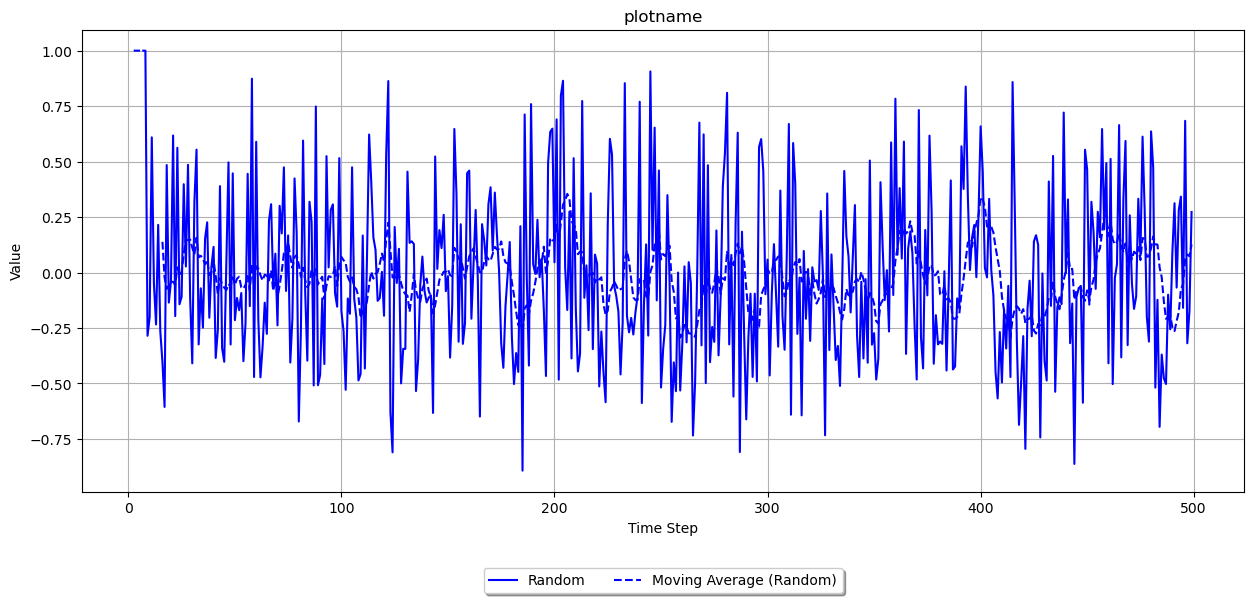

In [17]:
num_nodes=8
for conn in ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]:
    change_in=change_in_ex_work(conn,"greedy",newdata2,num_nodes)
    twoQdm= get_2_qbit_dms(newdata2,num_nodes,conn,"greedy")
        #twoQdmsweakmax = get_2_qbit_dms(newdata5,8,"c5","weakest_maximizes")
    adj_matrices_list = adjacency_matrices_list_two_dim(twoQdm,0, num_nodes,mutual_info_dicts)
    plot_one_stats_as_function_of_time(cal_pearson_for_best_worst_q(change_in[0],adj_matrices_list))

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_18712/1381565261.py:11: RuntimeWarning: invalid value encountered in scalar divide
  PC = Num/Denom


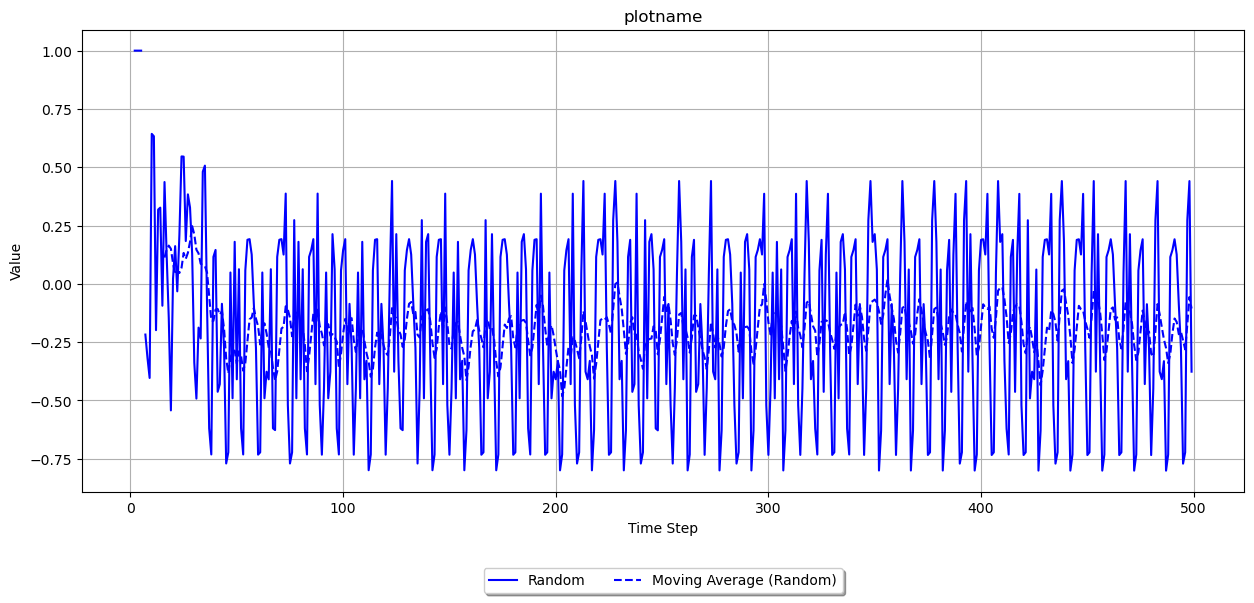

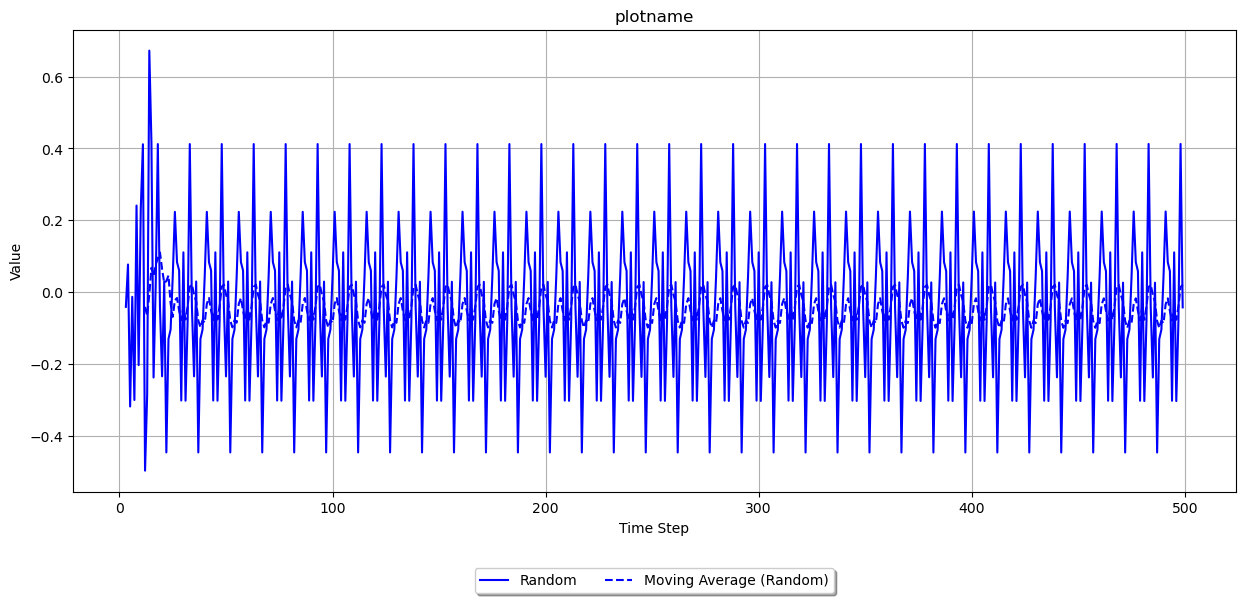

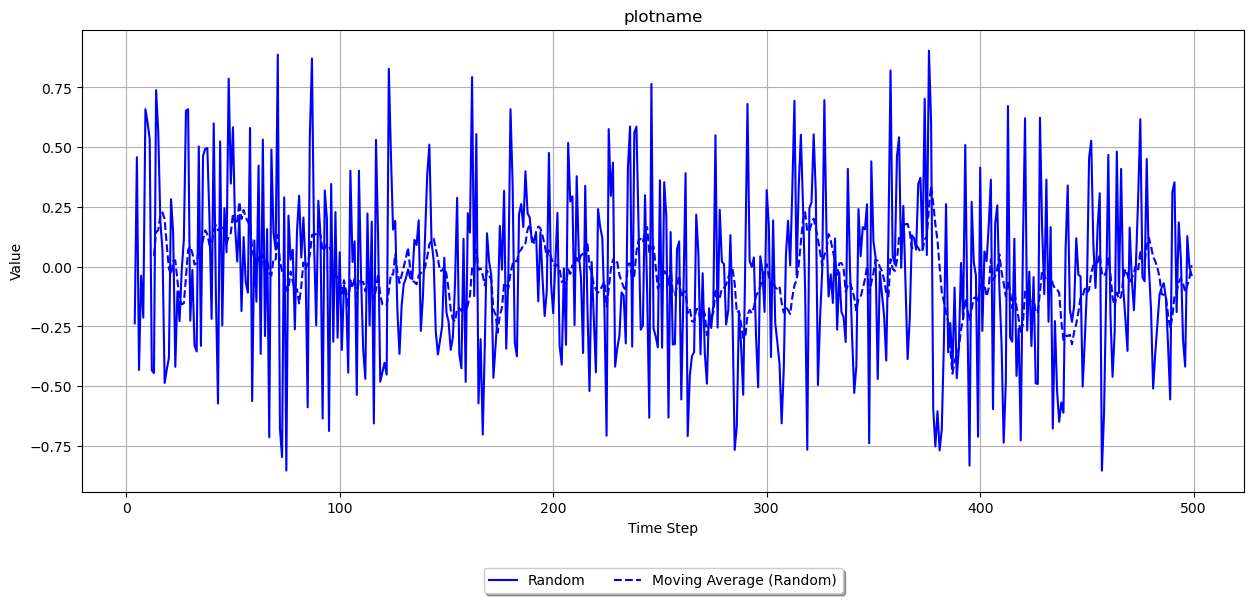

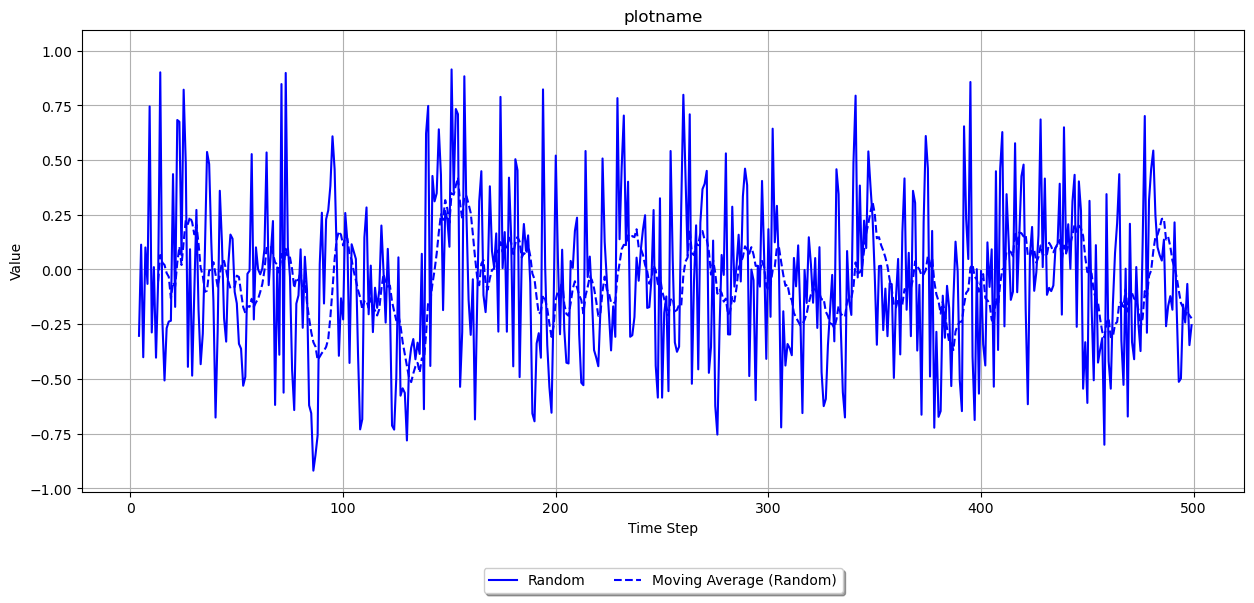

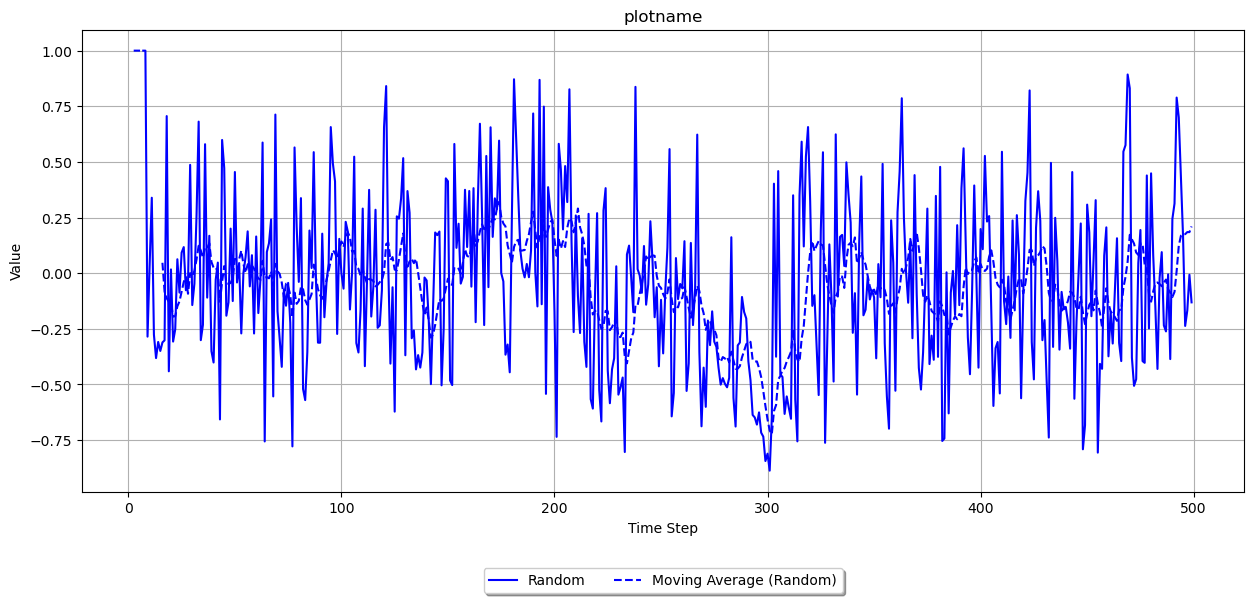

In [18]:
num_nodes=8
for conn in ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]:
    change_in=change_in_ex_work(conn,"mimic",newdata3,num_nodes)
    twoQdm= get_2_qbit_dms(newdata3,num_nodes,conn,"mimic")
        #twoQdmsweakmax = get_2_qbit_dms(newdata5,8,"c5","weakest_maximizes")
    adj_matrices_list = adjacency_matrices_list_two_dim(twoQdm,0, num_nodes,mutual_info_dicts)
    plot_one_stats_as_function_of_time(cal_pearson_for_best_worst_q(change_in[0],adj_matrices_list))

In [40]:
def disparity_of_q(adj_mat,q):
    adj_mat = np.array(adj_mat)
    M_row_sum_squared = np.sum(adj_mat, axis=1)**2
    M_row_sum_of_squared_elements = np.sum(adj_mat**2, axis=1)
    # Check for zero division before performing division
    Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)
    D_list=Di[q]
    return D_list

In [46]:
def disparity_of_q_network(adjacency_matrix_list):
    D_list = []
    adjacency_matrix_list=np.array(adjacency_matrix_list)
    for adj_mat in adjacency_matrix_list:
        M_row_sum_squared = np.sum(adj_mat, axis=1)**2
        M_row_sum_of_squared_elements = np.sum(adj_mat**2, axis=1)
        # Check for zero division before performing division
        Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)
        D_list.append(Di)
    return D_list

In [95]:
def disp_between_best_worst_q(change_in,adj_matrix):
    list_disp_bestq_worstq=[]
    for ind in range(len(change_in)) :
        max_value = np.max(change_in[ind])
        min_value = np.min(change_in[ind])
        abs_change=np.abs(max_value-min_value)
        change_list=[max_value,min_value]
        max_index = np.argmax(change_in[ind])
        min_index = np.argmin(change_in[ind])
        disp_list = [disparity_of_q(adj_matrix[ind],max_index),disparity_of_q(adj_matrix[ind],min_index)]
        list_disp_bestq_worstq.append([change_list,disp_list])
    return list_disp_bestq_worstq

In [28]:
num_nodes=8
for conn in ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]:
    change_in=change_in_ex_work(conn,"random",newdata1,num_nodes)
    twoQdm= get_2_qbit_dms(newdata1,num_nodes,conn,"random")
        #twoQdmsweakmax = get_2_qbit_dms(newdata5,8,"c5","weakest_maximizes")
    adj_matrices_list = adjacency_matrices_list_two_dim(twoQdm,0, num_nodes,mutual_info_dicts)
    plot_one_stats_as_function_of_time(disp_between_best_worst_q(change_in[0],adj_matrices_list))

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_18712/2538468526.py:6: RuntimeWarning: invalid value encountered in divide
  Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)


ValueError: object too deep for desired array

In [109]:
twoQdm= get_2_qbit_dms(newdata4,8,"c4_2local","landscape_maximizes")
adj_matrices_list = adjacency_matrices_list_two_dim(twoQdm,0, num_nodes,mutual_info_dicts)


In [110]:
list1=change_in_ex_work("c4_2local","landscape_maximizes",newdata4,8)[0]
list2=disparity_of_q_network(adj_matrices_list)


/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_18712/2777090755.py:8: RuntimeWarning: invalid value encountered in divide
  Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)


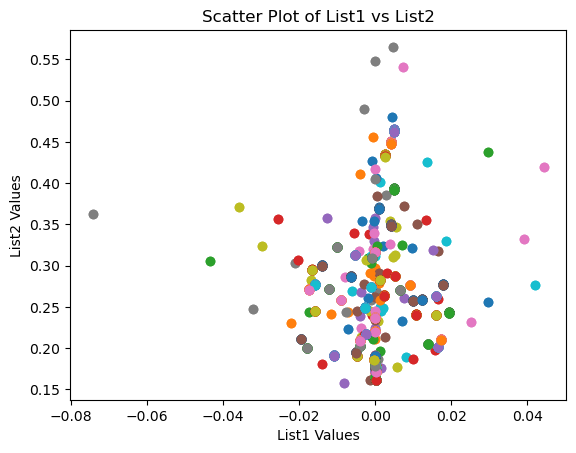

In [76]:
for inde in range(499):
    xx = list1[inde]
    yy = list2[inde+1]
    
    # Creating the scatter plot
    plt.scatter(xx, yy)
    
    # Adding labels and title
    plt.xlabel('List1 Values')
    plt.ylabel('List2 Values')
    plt.title('Scatter Plot of List1 vs List2')
    
    # Displaying the plot
plt.show()

/var/folders/x8/hv6lnsx5209d4m84b842j095n23ctf/T/ipykernel_18712/2538468526.py:6: RuntimeWarning: invalid value encountered in divide
  Di = np.where(M_row_sum_squared != 0, M_row_sum_of_squared_elements / M_row_sum_squared, 0)


IndexError: list index out of range

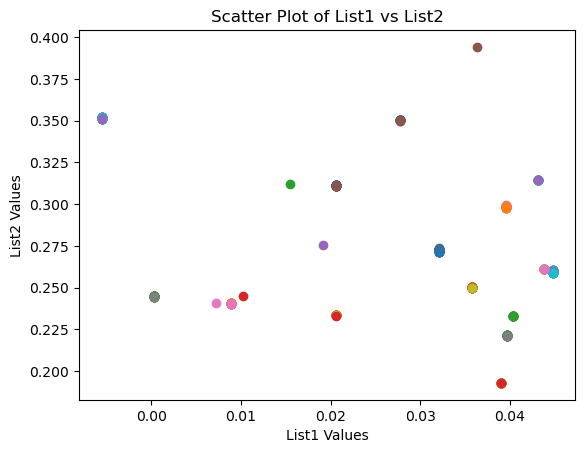

In [111]:
mega_list=disp_between_best_worst_q(list1,adj_matrices_list)
for inde in range(499):
    xx = mega_list[inde][0][0]
    yy = mega_list[inde+1][1][0]
    
    # Creating the scatter plot
    plt.scatter(xx, yy)
    
    # Adding labels and title
    plt.xlabel('List1 Values')
    plt.ylabel('List2 Values')
    plt.title('Scatter Plot of List1 vs List2')
    
    # Displaying the plot
plt.show()

In [112]:
def average_values_two_point_list(adj_matrices_list):
    average_values_two_point_list=[]
    for adj_matrix in adj_matrices_list:
        adj_matrix_form = np.matrix(adj_matrix)
        average_values_two_point = adj_matrix_form.sum(axis=1)
        average_values_two_point=np.array(average_values_two_point).flatten()
        average_values_two_point=np.real(average_values_two_point)
        average_values_two_point_list.append(average_values_two_point)
    return average_values_two_point_list

In [123]:
twoQdm= get_2_qbit_dms(newdata3,8,"c2_2local","mimic")
adj_matrices_list = adjacency_matrices_list_two_dim(twoQdm,0, num_nodes,mutual_info_dicts)
list1=change_in_ex_work("c2_2local","mimic",newdata3,8)[0]
list2=average_values_two_point_list(adj_matrices_list)

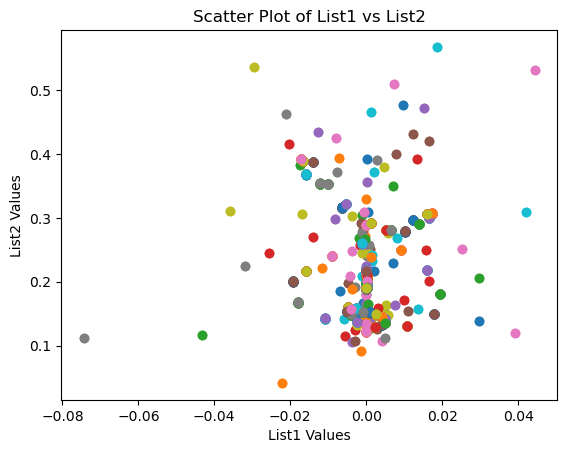

In [127]:
for inde in range(499):
    xx = list1[inde]
    yy = list2[inde]
    
    # Creating the scatter plot
    plt.scatter(xx, yy)
    
    # Adding labels and title
    plt.xlabel('List1 Values')
    plt.ylabel('List2 Values')
    plt.title('Scatter Plot of List1 vs List2')
    
    # Displaying the plot
plt.show()

In [154]:
pops = get_pops(newdata4,8,"c2_2local","landscape_maximizes")


In [161]:
pops[0][4:20]

array([[0.31310812, 0.16527848, 0.02161364, 0.02161365, 0.3131081 ,
        0.16527846, 0.        , 0.        ],
       [0.21419084, 0.26419577, 0.02161365, 0.02161365, 0.21419084,
        0.26419577, 0.        , 0.        ],
       [0.18734851, 0.25277537, 0.048456  , 0.048456  , 0.18734851,
        0.25277537, 0.01142046, 0.01142046],
       [0.10178599, 0.3383379 , 0.04845601, 0.04845601, 0.10178599,
        0.3383379 , 0.01142046, 0.01142046],
       [0.07929542, 0.29947641, 0.07094657, 0.07094657, 0.07929543,
        0.2994764 , 0.05028201, 0.05028202],
       [0.05608306, 0.23907089, 0.09415895, 0.09415895, 0.05608307,
        0.23907089, 0.11068756, 0.11068756],
       [0.03616254, 0.16756606, 0.11407949, 0.11407948, 0.03616255,
        0.16756606, 0.18219243, 0.18219244],
       [0.02297828, 0.09732571, 0.12726375, 0.12726375, 0.02297828,
        0.09732571, 0.25243282, 0.25243282],
       [0.01880997, 0.04049507, 0.13143209, 0.13143209, 0.01880997,
        0.04049507, 0.309263

<function matplotlib.pyplot.show(close=None, block=None)>

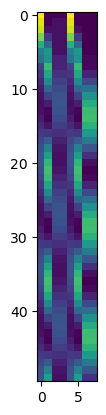

In [165]:
plt.imshow(pops[0][0:50], interpolation='none')
plt.show

In [157]:
(0.5 * np.cos(np.pi/15)**2)*np.cos(np.pi/15)**2

0.457707027308079